# Introduction

Understanding biomechanical factors in spinal disorders is essential for diagnosis and treatment planning. This project applies supervised learning, imputation strategies, dimensionality reduction, and interpretability tools (e.g. SHAP values) on a real-world spinal dataset to uncover patterns and assess model robustness. A range of methods are tested, from classical statistical imputation to ensemble learning. The goal is not only predictive accuracy but also interpretability and preservation of biomechanical relationships.

In [96]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn.manifold import TSNE, trustworthiness
from constants import *
from scipy import stats
from joblib import Memory

from sklearn.base import clone
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
)

from sklearn.preprocessing import (
    PowerTransformer,
    StandardScaler,
    LabelEncoder,
    label_binarize,
)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    IsolationForest,
    RandomForestClassifier,
    RandomForestRegressor,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
    brier_score_loss,
    precision_recall_curve,
    average_precision_score,
)


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_decision_regions
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

IMPUTATION_COLUMNS = [
    'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope'
]
FEATURE_COLS = [
    'pelvic_incidence', 'lumbar_lordosis_angle', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope'
]


## Literature Review
The prediction and classification of spinal disorders using machine learning methods have received significant attention due to their ability to provide accurate, consistent, and rapid diagnostic support compared to traditional approaches. 

Spondylolisthesis, characterized by vertebral slippage, has traditionally been diagnosed through manual analysis of X-ray images, which is prone to inter-rater variability and human error (Vephasayanant et al., 2024). 

Recent advancements in feature extraction and classification have significantly improved diagnostic outcomes. For instance, histogram-oriented gradient (HOG) techniques enhanced with anisotropic diffusion and weighting schemes (Saechueng & Suttapakti, 2023) have demonstrated superior accuracy in capturing vertebral shifts crucial for spondylolisthesis diagnosis. Moreover, recent developments in deep learning such as YOLO-based segmentation have shown high precision in vertebral localization and condition classification, emphasising the benefits of computer vision for improved diagnostic accuracy (Vephasayanant et al., 2024). 

Other studies have explored machine learning techniques, including Random Forest, XGBoost, and Neural Networks, showcasing their ability to handle the non-linear relationships inherent in biomechanical data effectively (Jitpattanakul et al., 2024; Klinwichit et al., 2023). Collectively, these methodologies underline the importance of robust feature extraction, dimensionality reduction, and advanced model selection for enhancing the prediction accuracy and clinical utility of machine learning in spinal disorder diagnosis.



# Data Cleaning & Imputation Techniques

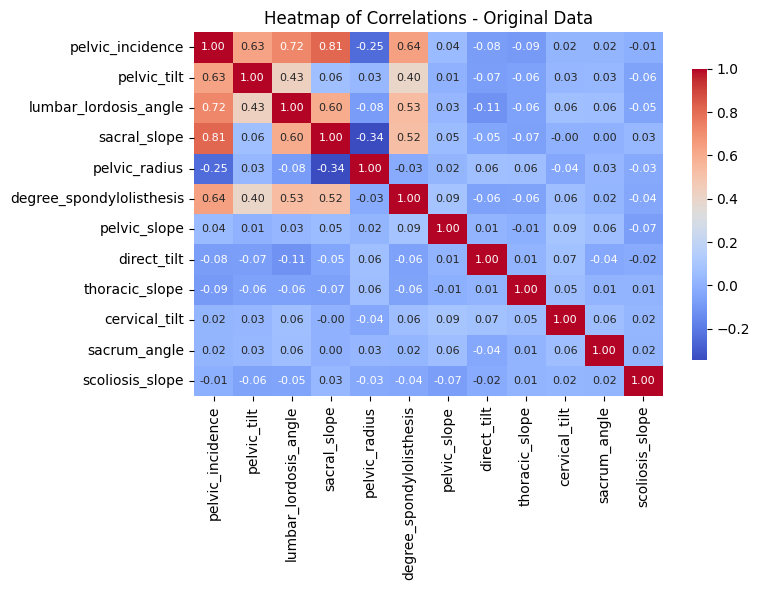

In [97]:
# Loading data
unclean_data = pd.read_csv('./data_set/combined.csv')
unclean_data.head()

# Remove the class column to get only numeric columns for the heatmap
numeric_data = unclean_data.copy().drop(columns=['class'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", annot_kws={'size':8}, cbar_kws={'shrink': .8})
plt.title('Heatmap of Correlations - Original Data', fontsize=12)
plt.tight_layout()
plt.show()

## Problematic Overlap Between Abnormal, Hernia and Spondylolisthesis Labels

In the dataset, the three non‐normal categories abnormal, hernia and spondylolisthesis suffer from two key issues:

1. Abnormal Is a Heterogeneous Catch-All
The abnormal label groups together a wide variety of minor pathologies: early hernias, mild spondylolisthesis, small deformities, etc. Because these sub-conditions span the same biomechanical ranges as the more specific classes, their feature distributions overlap heavily with both hernia and spondylolisthesis. As a result, models struggle to learn a coherent decision boundary for abnormal and often default to the majority subclass within it.

2. Burring Between Hernia and Spondylolisthesis
Key features such as pelvic tilt, sacral slope, lumbar lordosis angle and degree of spondylolisthesisshift gradually from healthy through hernia to spondylolisthesis. There is no sharp threshold in these measurements at which a hernia becomes a spondylolisthesis—clinically, the transition is a continuum. In practice, this means samples with moderate displacement may be labeled inconsistently, introducing label noise and confusing the classifier.

Implications for Modeling 
- High Label Noise: Overlapping ranges and catch-all categories inflate mislabel rates.  
- Poor Class Separability: Algorithms cannot find clear hyperplanes when feature clusters bleed into one another.  
- Reduced Predictive Power: Even powerful models (Random Forest, XGBoost) plateau around 55–60% accuracy, as they cannot reconcile ambiguous labels.

Next Steps 
- Refine or Relabel Abnormal: Split it into more homogeneous subgroups or reassign borderline cases to hernia/spondylolisthesis based on stronger biomechanical criteria.  
- Define Numeric Cutoffs: Establish clinically justified thresholds (e.g. degree of slippage > X°) to better demarcate hernia vs. spondylolisthesis.

In [98]:
THRESHOLDS = {
    'degree_spondylolisthesis': {
        'normal': (-float('inf'), 2.0),
        'hernia': (2.0, 5.0),
        'spondylolisthesis': (5.0, float('inf')),
    },
    'pelvic_tilt': {
        'normal': (-float('inf'), 10.0),
        'hernia': (10.0, 15.0),
        'spondylolisthesis': (15.0, float('inf')),
    },
    'sacral_slope': {
        'normal': (-float('inf'), 30.0),
        'hernia': (30.0, 40.0),
        'spondylolisthesis': (40.0, float('inf')),
    },
    # Add additional features as needed
}

def classify_row(row, thresholds):
    """
    For a given row, vote across all features in thresholds dict,
    and return the label with the most votes.
    """
    votes = {label: 0 for label in ['normal', 'hernia', 'spondylolisthesis']}
    for feat, bins in thresholds.items():
        val = row.get(feat, None)
        if pd.isna(val):
            continue
        for label, (low, high) in bins.items():
            if low <= val < high:
                votes[label] += 1
                break
    # Return the label with the highest vote count. In case of a tie, this picks the first max by key order
    return max(votes, key=votes.get)

# Make a copy to preserve the original
updated_df = unclean_data.copy()

mask = updated_df['class'] == 'abnormal'
updated_df.loc[mask, 'class'] = updated_df.loc[mask].apply(classify_row, axis=1, thresholds=THRESHOLDS)

print(updated_df['class'].value_counts().loc[['hernia','spondylolisthesis']], "among former 'abnormal' rows")
updated_df.to_csv('./data_set/combined_fixed.csv', index=False)
print("Saved updated CSV to ./data_set/combined_fixed.csv")

unclean_data = updated_df

class
hernia                292
spondylolisthesis    1577
Name: count, dtype: int64 among former 'abnormal' rows
Saved updated CSV to ./data_set/combined_fixed.csv


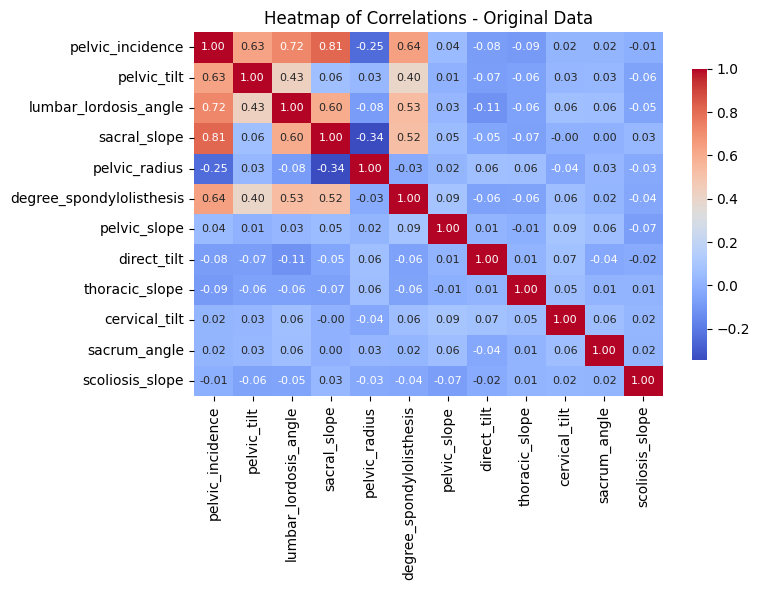

In [99]:
# Remove the 'class' column to get only numeric columns for the heatmap
numeric_data = unclean_data.copy().drop(columns=['class'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", annot_kws={'size':8}, cbar_kws={'shrink': .8})
plt.title('Heatmap of Correlations - Original Data', fontsize=12)
plt.tight_layout()
plt.show()

In [100]:
# NaNs and Blank Columns
nan_counts = unclean_data.isna().sum()
blank_counts = (unclean_data == '').sum()

counts = pd.DataFrame({
    'nan_count': nan_counts,
    'blank_count': blank_counts
})

print(counts)


                          nan_count  blank_count
pelvic_incidence                  0            0
pelvic_tilt                       0            0
lumbar_lordosis_angle             0            0
sacral_slope                      0            0
pelvic_radius                     0            0
degree_spondylolisthesis          0            0
class                             0            0
pelvic_slope                   1550            0
direct_tilt                    1550            0
thoracic_slope                 1550            0
cervical_tilt                  1550            0
sacrum_angle                   1550            0
scoliosis_slope                1550            0


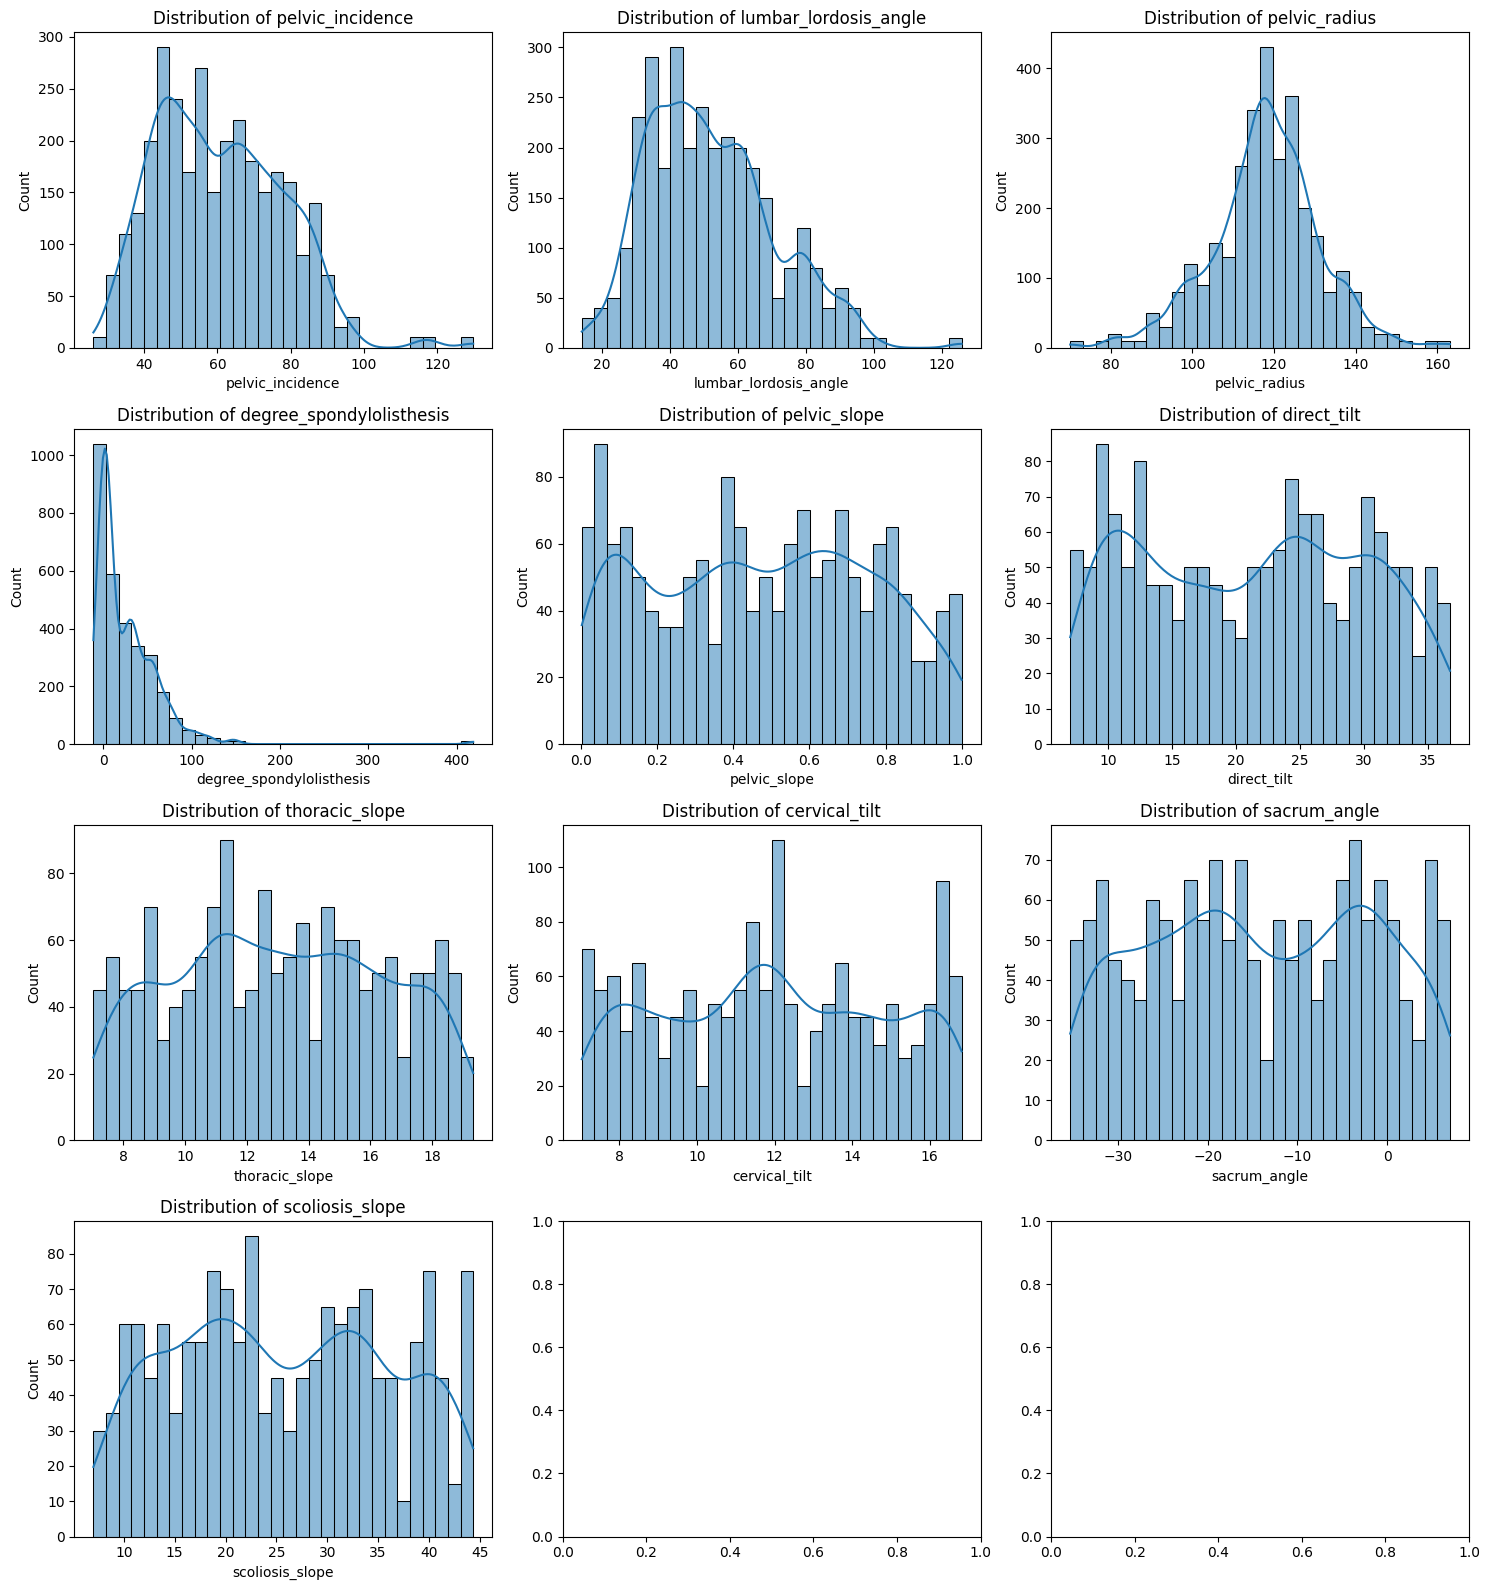

In [101]:
# Distribution histograms of only numeric features
ncols = 3
nrows = math.ceil(len(FEATURE_COLS) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
axes = axes.flatten()
for ax, col in zip(axes, FEATURE_COLS):
    sns.histplot(unclean_data[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


The distributions above show missing values and possible skew in several features. This motivates our next step: trying different imputation methods to recover these values in a statistically meaningful way.

This data has 6 columns with approximately half having accurate float information and the remaining half is recorded as NaN. There are several options we can explore. 

1. We can use the data while removing the last 6 columns leaving 3000 rows of data and 7 columns. For a preliminary analysis we can drop the features initially. 

2. We can keep only complete records of data which will leave 1500 rows of data with 13 columns. Although this improves reliability, it is at the cost of reducing the sample size.

3. Lastly we can impute the missing information. In spinal biomechanics, they are mathematically interrelated. Pelvic Incidence, Sacral Slope and Pelvic Tilt are particularly useful because it can be demonstrated that Pelvic Incidence (PI) is the arithmetic sum of the sacral slope (SS), pelvic tilt (PT), the two position-dependent variables that determine pelvic orientation in the sagittal plane (Labelle et al., 2005). Normalization will also be applied to mitigate issues with feature scaling. (Jolliffe, 2011)

## Imputation Techniques

Missing data mechanisms can be broadly categorised into MCAR (Missing Completely At Random), MAR (Missing At Random), and MNAR (Missing Not At Random)  
(Little & Rubin, 2002). The choice of imputation method can significantly influence statistical validity and model accuracy.

Let $X$ be the complete data matrix and $\hat{X}$ the imputed matrix. The objective is to minimise the reconstruction error:

$$
\min ||X - \hat{X}||^2
$$

KNN imputation uses Euclidean distance in the feature space to estimate missing values:

$$
d(x_i, x_j) = \sqrt{\sum_{k=1}^n (x_{ik} - x_{jk})^2}
$$

This method assumes that similar samples (based on surrounding feature values) are likely to have similar values in the missing fields.

## Missing Value Imputation
We will implement several imputation methods and evaluate their effects on the dataset. 

**Mean Imputation:** Missing values can be replaced with the mean of the feature. this is simple but can be influenced by outliers, potentially skewing the distribution. It can reduce variance since all missing entries are filled with an average value (C. Hounmenou, 2024)

**Median Imputation:** Replace missing values with the median of the feature. Median tends to be more robust to outliers then the mean, so this method preserves the central tendency without being dragged by extreme values. In practice, mean and median can often yield similar results for symmetric distributions, but median imputation can better maintain the distribution shape when the data is skewed or contains outliers (M. Badiaa, 2024).

**K-Nearest Neighbours Imputation (KNN):** Using KNN estimates missing values using the mean, or median, of the <i>k</i> closest records, the feature space, that have values for that feature. This method leverages relationships between features, under the assumption that similar samples have similar feature values. By considering the distance in all dimensions, KNN imputation can preserve the multivariate structure of the data, often leading to more plausible imputed values (T. Kaur, 2025). 

**Regression-based Imputation (Iterative/MICE):** Uses regression models in an iterative fashion to predict missing values. Methods like MICE, Multiple Imputation by Chained Equations, or MissForest, treat each feature with missing data as a target and learn a regression, or decision tree, model from other features to predict the missing value (Y. Sun et al, 2023). This approach takes into account dependencies between variables and often yields higher quality imputations than mean/ median filling. It learns the likely value of a feature based on rather, rather than inserting a constant value (T. Lekhansh, 2024). 

## Evaluation of Imputation Techniques
After imputing missing values using each method, we will examine how they affect the data distribution and model performance. 

**Distribution Effects:** We will visualise and summarise the distribution of key features before and after imputation. For example, histograms and density plots will be compared to see if the mean or median imputation significantly shifts the distribution or compresses variability. 

Mean imputation may underestimate variance, since many values become the mean, whereas KNN or regression imputation may preserve the natural variance by inferring different values for different samples. We'll also check if any imputation methods might preserve relationships between feature, whereas mean/ median could break those correlations. 

**Model Performance:** We will train a baseline machine learning model, such as a logistic regression and compare their accuracy before and after imputation. The intuition is that a better imputation method provides data closer to the truth, potentially improving model accuracy. For example, median imputation might improve robustness on datasets with outliers, and more sophisticated approaches like KNN or MICE often yield higher predictive performance (lower error) since they utilise additional information from other features (S. Alam, 2023). By evaluating the model’s accuracy after each imputation, we can quantify the impact of each cleaning method. Any improvement in accuracy or reduction in error when using KNN/MICE over simple mean imputation would indicate that preserving multivariate structure is beneficial for this dataset.

Throughout this process, careful cross-validation will be used to ensure that the comparisons are fair, so differences in performance are due to imputation rather than random train test splits or variance in random state. 

In [102]:
# Outlier detection cell
iso = IsolationForest(contamination=0.02, random_state=FORTY_TWO)
outlier_labels = iso.fit_predict(unclean_data[FEATURE_COLS])

cleaned_data = unclean_data.loc[outlier_labels == 1].reset_index(drop=True)
print(f"Dropped {sum(outlier_labels == -1)} rows; remaining = {len(cleaned_data)}")

X_all = cleaned_data.drop(columns=['class'])
y_all = cleaned_data['class']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=FORTY_TWO, stratify=y_all)

FEATURE_COLS = X_all.columns.tolist()


Dropped 60 rows; remaining = 3040


In [103]:
min_max = cleaned_data[FEATURE_COLS].agg(['min', 'max']).T
min_max.columns = ['minimum', 'maximum']

print(min_max)

                            minimum     maximum
pelvic_incidence          30.149936   96.660000
pelvic_tilt               -6.554948   49.431864
lumbar_lordosis_angle     15.500000  125.742385
sacral_slope              13.366931   78.794052
pelvic_radius             70.080000  163.071041
degree_spondylolisthesis -11.060000  148.753711
pelvic_slope               0.003220    0.998827
direct_tilt                7.027000   36.743900
thoracic_slope             7.037800   19.324000
cervical_tilt              7.030600   16.821080
sacrum_angle             -35.287375    6.972071
scoliosis_slope            7.007900   44.341200


In [104]:
# Scaling cell & Yeo–Johnson cell
df_clean = cleaned_data.copy()
FEATURE_COLS = df_clean.select_dtypes(include=['float64','int64']).columns.tolist()

complete_rows = cleaned_data.dropna(subset=IMPUTATION_COLUMNS)
impute_train, impute_val = train_test_split(complete_rows, test_size=0.2, random_state=FORTY_TWO)

pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(impute_train[FEATURE_COLS])
impute_train[FEATURE_COLS] = pt.transform(impute_train[FEATURE_COLS])
impute_val[FEATURE_COLS] = pt.transform(impute_val[FEATURE_COLS])

scaler = StandardScaler()
scaler.fit(impute_train[FEATURE_COLS])
impute_train[FEATURE_COLS] = scaler.transform(impute_train[FEATURE_COLS])
impute_val[FEATURE_COLS] = scaler.transform(impute_val[FEATURE_COLS])

pt_full = pt.transform(df_clean[FEATURE_COLS])
scaled_full = scaler.transform(pt_full)
data_scaled = df_clean.copy()
data_scaled[FEATURE_COLS] = scaled_full

X_eval_original = impute_val.copy()
X_eval_missing = impute_val.copy()

np.random.seed(FORTY_TWO)
for col in IMPUTATION_COLUMNS:
    miss_idx = X_eval_missing.sample(frac=0.2).index
    X_eval_missing.loc[miss_idx, col] = np.nan

imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'Regression': IterativeImputer(random_state=FORTY_TWO),
}

for name, imputer in imputers.items():
    print(f"\n--- {name} Imputation Results ---")
    imputer.fit(impute_train[FEATURE_COLS])

    X_imp_scaled = X_eval_missing.copy()
    X_imp_scaled[FEATURE_COLS] = imputer.transform(X_eval_missing[FEATURE_COLS])

    # invert scaling to compute MSE/R² in original units
    X_imp_orig = X_imp_scaled.copy()
    X_imp_orig[FEATURE_COLS] = scaler.inverse_transform(X_imp_scaled[FEATURE_COLS])
    X_eval_orig = X_eval_original.copy()
    X_eval_orig[FEATURE_COLS] = scaler.inverse_transform(X_eval_original[FEATURE_COLS])

    for col in IMPUTATION_COLUMNS:
        mask = X_eval_missing[col].isna()
        mse = mean_squared_error(X_eval_orig.loc[mask, col], X_imp_orig.loc[mask, col])
        r2 = r2_score(X_eval_orig.loc[mask, col], X_imp_orig.loc[mask, col])
        print(f"{col}: MSE = {mse:.6f}, R² = {r2:.6f}")

    combined = pd.concat([impute_train, X_imp_scaled]).sort_index()
    print(f"\n{name} - Correlation matrix after imputation:")
    print(combined[IMPUTATION_COLUMNS].corr())

# full‐data KNN for the final dataset
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(data_scaled[FEATURE_COLS])
imputed_full = knn_imputer.transform(data_scaled[FEATURE_COLS])

final = data_scaled.copy()
cols_ix = [FEATURE_COLS.index(c) for c in IMPUTATION_COLUMNS]
final[IMPUTATION_COLUMNS] = imputed_full[:, cols_ix]

X = final.drop(columns=['class'])
y = final['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=FORTY_TWO, stratify=y)



--- Mean Imputation Results ---
pelvic_slope: MSE = 0.063065, R² = -0.008260
direct_tilt: MSE = 12.597411, R² = -0.044869
thoracic_slope: MSE = 2.982832, R² = -0.005259
cervical_tilt: MSE = 1.322009, R² = -0.000095
sacrum_angle: MSE = 92.651343, R² = -0.013345
scoliosis_slope: MSE = 11.400337, R² = -0.000472

Mean - Correlation matrix after imputation:
                 pelvic_slope  direct_tilt  thoracic_slope  cervical_tilt  \
pelvic_slope         1.000000     0.016635       -0.010197       0.093931   
direct_tilt          0.016635     1.000000        0.006286       0.096831   
thoracic_slope      -0.010197     0.006286        1.000000       0.049429   
cervical_tilt        0.093931     0.096831        0.049429       1.000000   
sacrum_angle         0.044841    -0.034482        0.023770       0.046781   
scoliosis_slope     -0.087487    -0.012304        0.024125       0.011007   

                 sacrum_angle  scoliosis_slope  
pelvic_slope         0.044841        -0.087487  
direct

In [105]:
outlier_labels = iso.fit_predict(unclean_data[FEATURE_COLS])
inlier_mask = outlier_labels == 1

min_max_scaled = data_scaled[FEATURE_COLS].agg(['min','max']).T
min_max_scaled.columns = ['minimum (scaled)', 'maximum (scaled)']
print(min_max_scaled)

                          minimum (scaled)  maximum (scaled)
pelvic_incidence                 -2.185143          2.055109
pelvic_tilt                      -3.192212          3.008617
lumbar_lordosis_angle            -2.898331          3.049438
sacral_slope                     -2.789299          2.682763
pelvic_radius                    -3.315839          3.714518
degree_spondylolisthesis         -3.365284          2.765137
pelvic_slope                     -1.688685          1.781834
direct_tilt                      -1.786217          1.675445
thoracic_slope                   -1.845038          1.759469
cervical_tilt                    -1.746954          1.636494
sacrum_angle                     -1.580044          2.075462
scoliosis_slope                  -1.977802          1.647408


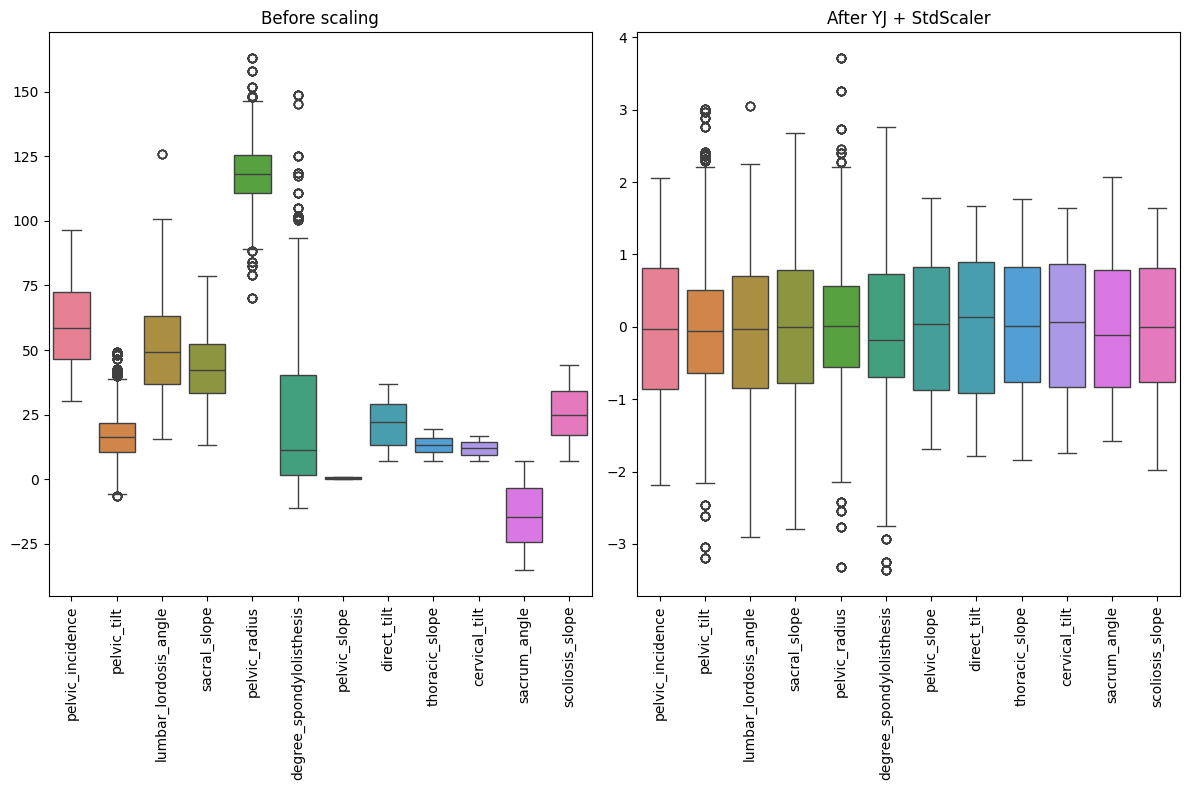

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Before scaling
sns.boxplot(data=cleaned_data[FEATURE_COLS], ax=axes[0])
axes[0].set_title("Before scaling")
axes[0].tick_params(axis='x', rotation=90)

# After scaling
sns.boxplot(data=data_scaled[FEATURE_COLS], ax=axes[1])
axes[1].set_title("After YJ + StdScaler")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## Why Gaussianity Matters & the Yeo–Johnson Transform
Most machine‑learning methods, from linear models to distance‑based learners and even tree‑based algorithms, tend to perform better when features are roughly symmetrically distributed. Heavy skew or long tails can distort distance metrics (e.g. in KNN, SMOTE, SVM), slow convergence (e.g. in gradient‑based methods like neural nets) and make outliers disproportionately affect models that rely on a uniform spread of the data’s variability.

A simple histogram can reveal skew. To mitigate it, we can apply a power transform, which raises each feature to a learned exponent λ so as to pull in extremes:

$$
x^{(\lambda)} = 
\begin{cases}
\dfrac{(x+1)^\lambda - 1}{\lambda}, & \lambda \neq 0, \\[6pt]
\ln(x+1), & \lambda = 0.
\end{cases}
$$
    ​
    
The Box–Cox variant above only works on strictly positive x. Yeo–Johnson extends this to any real x, by treating positive and negative values slightly differently:

$$
x^{(\lambda)} = 
\begin{cases}
\dfrac{(x+1)^\lambda - 1}{\lambda}, & x \ge 0,\ \lambda \neq 0, \\[6pt]
\ln(x+1), & x \ge 0,\ \lambda = 0, \\[6pt]
-\dfrac{(-x+1)^{\,2-\lambda} - 1}{2 - \lambda}, & x < 0,\ \lambda \neq 2, \\[6pt]
-\ln(-x+1), & x < 0,\ \lambda = 2.
\end{cases}
$$

We fit λ on your train‐set so that the transformed distribution is as close to normal as possible. We then standardise, centering at zero and scaling to unit variance. After this, features that were previously skewed become much more bell‑shaped, which often improves both optimisation and final predictive performance.

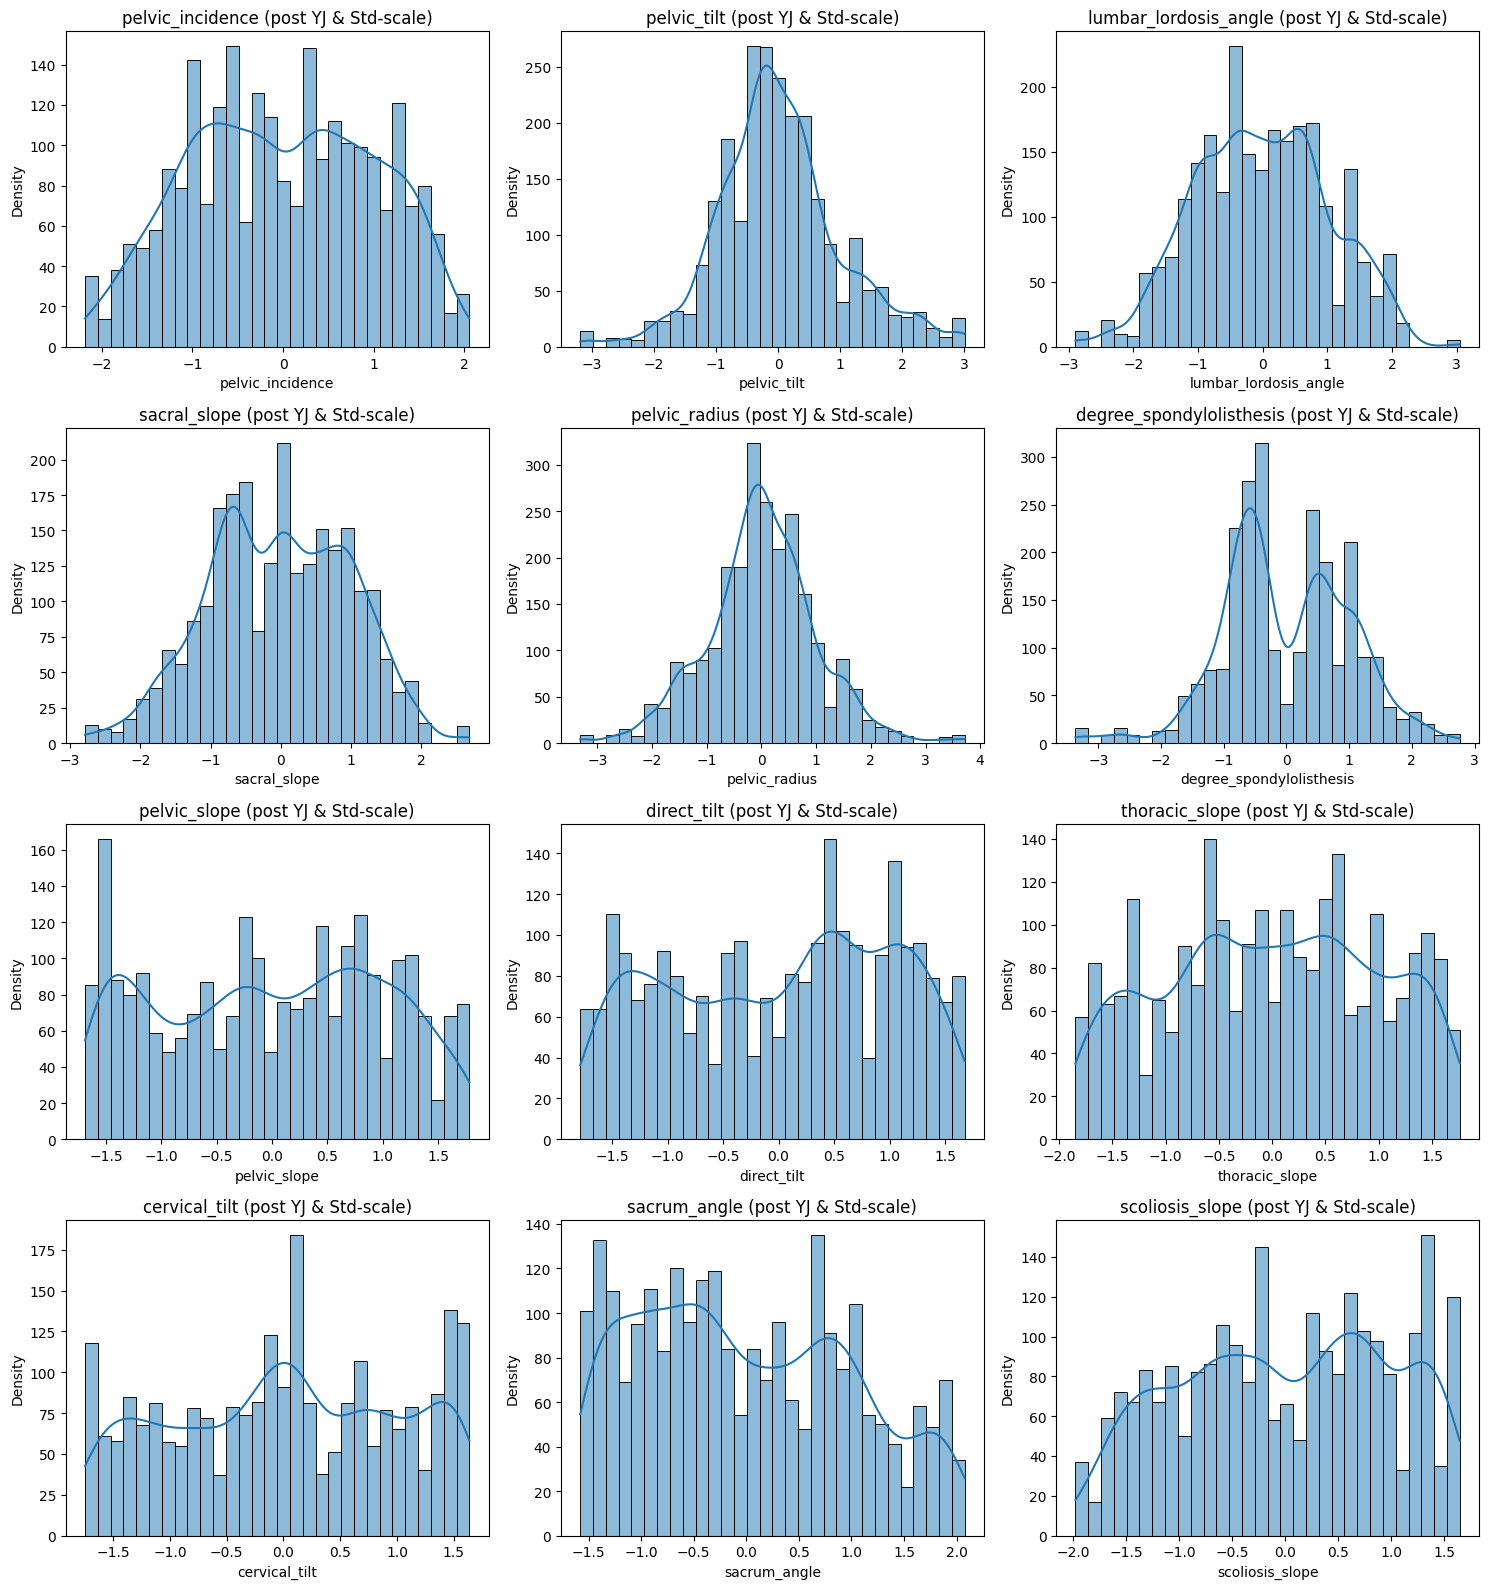

In [107]:
X_train_df = pd.DataFrame(X_train, columns=FEATURE_COLS)
features = X_train

ncols = 3
nrows = math.ceil(len(FEATURE_COLS) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for ax, col in zip(axes, FEATURE_COLS):
    sns.histplot(X_train_df[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"{col} (post YJ & Std-scale)")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    
plt.tight_layout()
plt.show()

# Multicollinearity and Variance Inflation Factors

Multicollinearity occurs when two or more predictor variables in a regression or classification model are highly linearly related. In practice, this means that one feature can be, nearly, exactly predicted from the others, which inflates the variance of the estimated coefficients, makes the model unstable, and undermines interpretability. One standard way to quantify multicollinearity is the Variance Inflation Factor (VIF) for each feature:

$$
\mathrm{VIF}_j \;=\; \frac{1}{1 - R_j^2}
$$​
In many applied settings, a rule of thumb is to aim for VIFs < 5, certainly < 10, to ensure robust, interpretable models. 

By removing Pelvic Tilt and Sacral Slope, leaving Pelvic Incidence as the single <i>master</i> angle, and dropping the extra tilt and slope measurements, direct tilt, cervical tilt, thoracic slope and scoliosis slope, we eliminate the redundant chains of spinal angles that were pushing VIFs well above 100. After that domain pruning, every remaining feature has a VIF under 5, and most are close to 1–3, confirming that each now contributes largely independent information. This streamlined set of FEATURE_COLS keeps the model stable and the coefficients interpretable, without over-counting the same biomechanical signal.

In [108]:
# Check for multicollinearity using VIF (Variance Inflation Factor)
feats = X_train_df.columns.tolist()
vif_data = pd.DataFrame({
    'feature': feats,
    'VIF': [
        variance_inflation_factor(X_train_df.values, i) 
        for i in range(len(feats))
    ]
})
print(vif_data.sort_values('VIF', ascending=False))


                     feature         VIF
0           pelvic_incidence  204.077402
3               sacral_slope  117.593991
1                pelvic_tilt   75.201783
2      lumbar_lordosis_angle    3.040386
5   degree_spondylolisthesis    1.897895
4              pelvic_radius    1.184684
7                direct_tilt    1.045100
9              cervical_tilt    1.038097
6               pelvic_slope    1.024599
11           scoliosis_slope    1.017238
10              sacrum_angle    1.013159
8             thoracic_slope    1.008466


In [109]:
cols_to_drop = [
    'pelvic_incidence', 'sacral_slope'
]

X_reduced = X_train.drop(columns=cols_to_drop)

vif_reduced = pd.DataFrame({
    'feature': X_reduced.columns,
    'VIF': [
        variance_inflation_factor(X_reduced.values, i)
        for i in range(X_reduced.shape[1])
    ]
})
print(vif_reduced.sort_values('VIF', ascending=False))


                    feature       VIF
3  degree_spondylolisthesis  1.861724
1     lumbar_lordosis_angle  1.786203
0               pelvic_tilt  1.277422
5               direct_tilt  1.037809
2             pelvic_radius  1.033943
7             cervical_tilt  1.033390
4              pelvic_slope  1.014825
9           scoliosis_slope  1.011754
8              sacrum_angle  1.010582
6            thoracic_slope  1.007817


VIFS quantify how much of the variance of a regression coefficient is inflated because of linear relationships between FEATURE_COLS. In practice, a VIF score above 5 is often evidence of troublesome multicollinearity, at that point we would consider removing, combining or transforming features who VIF exceeds that threshold (Kim JH, 2019).

Having dropped the multicollinear columns (pelvic_incidence, sacral_slope), we now rebalance and re-tune the model on the lean feature set.


In [110]:
X_train_reduced = X_train_df.drop(columns=cols_to_drop)
y_train_reduced = y_train

vif_reduced = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'VIF': [variance_inflation_factor(X_train_reduced.values, i)
            for i in range(X_train_reduced.shape[1])]
})
print(vif_reduced.sort_values('VIF'))

smote = SMOTE(random_state=FORTY_TWO)
X_red_bal, y_red_bal = smote.fit_resample(X_train_reduced, y_train)

best_rf_red = RandomForestClassifier(random_state=FORTY_TWO)

best_rf_red.fit(X_red_bal, y_red_bal)
label_encoder = LabelEncoder().fit(y_red_bal)


                    feature       VIF
6            thoracic_slope  1.007817
8              sacrum_angle  1.010582
9           scoliosis_slope  1.011754
4              pelvic_slope  1.014825
7             cervical_tilt  1.033390
2             pelvic_radius  1.033943
5               direct_tilt  1.037809
0               pelvic_tilt  1.277422
1     lumbar_lordosis_angle  1.786203
3  degree_spondylolisthesis  1.861724


RF train acc (reduced): 0.9660141381185426


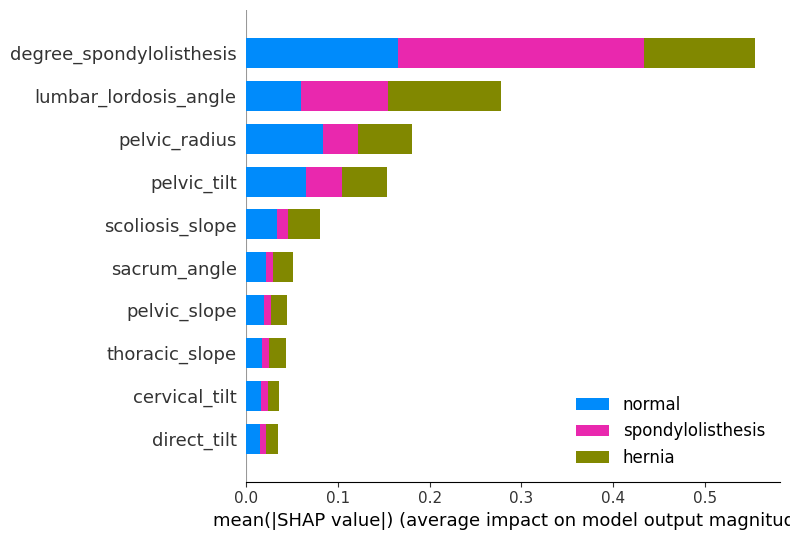

<Figure size 640x480 with 0 Axes>

In [111]:
# Build a DataFrame so SHAP can match feature names
reduced_cols = X_train_reduced.columns.tolist()
X_red_bal_df = pd.DataFrame(X_red_bal, columns=reduced_cols)

explainer_red = shap.TreeExplainer(best_rf_red)
shap_values_red = explainer_red.shap_values(X_red_bal_df)

print("RF train acc (reduced):", accuracy_score(y_red_bal, best_rf_red.predict(X_red_bal_df)))

# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values_red, X_red_bal_df, feature_names=reduced_cols, class_names=label_encoder.classes_)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_red, X_red_bal_df, plot_type="bar", feature_names=reduced_cols, class_names=label_encoder.classes_)  
plt.tight_layout()
plt.show()


1155   -0.021254
1357   -0.021254
747    -0.021254
545    -0.021254
343    -0.021254
dtype: float64


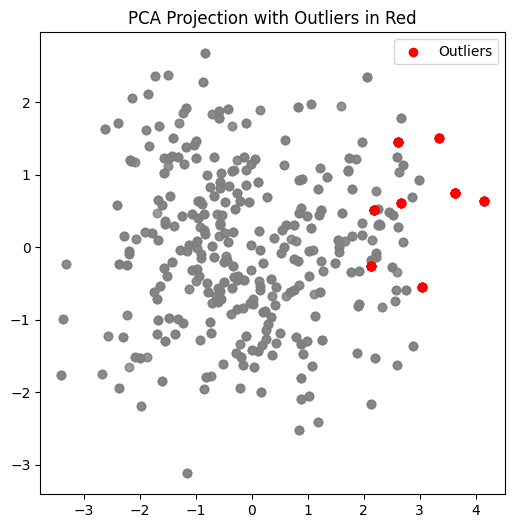

In [112]:
# Visualise outliears
iso_reduced = IsolationForest(contamination=0.02, random_state=FORTY_TWO)
iso_reduced.fit(cleaned_data[reduced_cols])
reduced_labels = iso_reduced.predict(cleaned_data[reduced_cols])

full_scores = pd.Series(iso_reduced.decision_function(cleaned_data[reduced_cols]), index=cleaned_data.index)
full_labels = pd.Series(reduced_labels, index=cleaned_data.index)

train_scores = full_scores.loc[X_train_reduced.index]
train_labels = full_labels.loc[X_train_reduced.index]

print(train_scores.nsmallest())

# PCA on X_train_df
pca2 = PCA(n_components=2, random_state=FORTY_TWO)
X2 = pca2.fit_transform(X_train_reduced)

plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1], c='gray', alpha=0.3)
plt.scatter(X2[train_labels == -1,0], X2[train_labels == -1,1], c='red', label='Outliers')
plt.legend()
plt.title("PCA Projection with Outliers in Red")
plt.show()


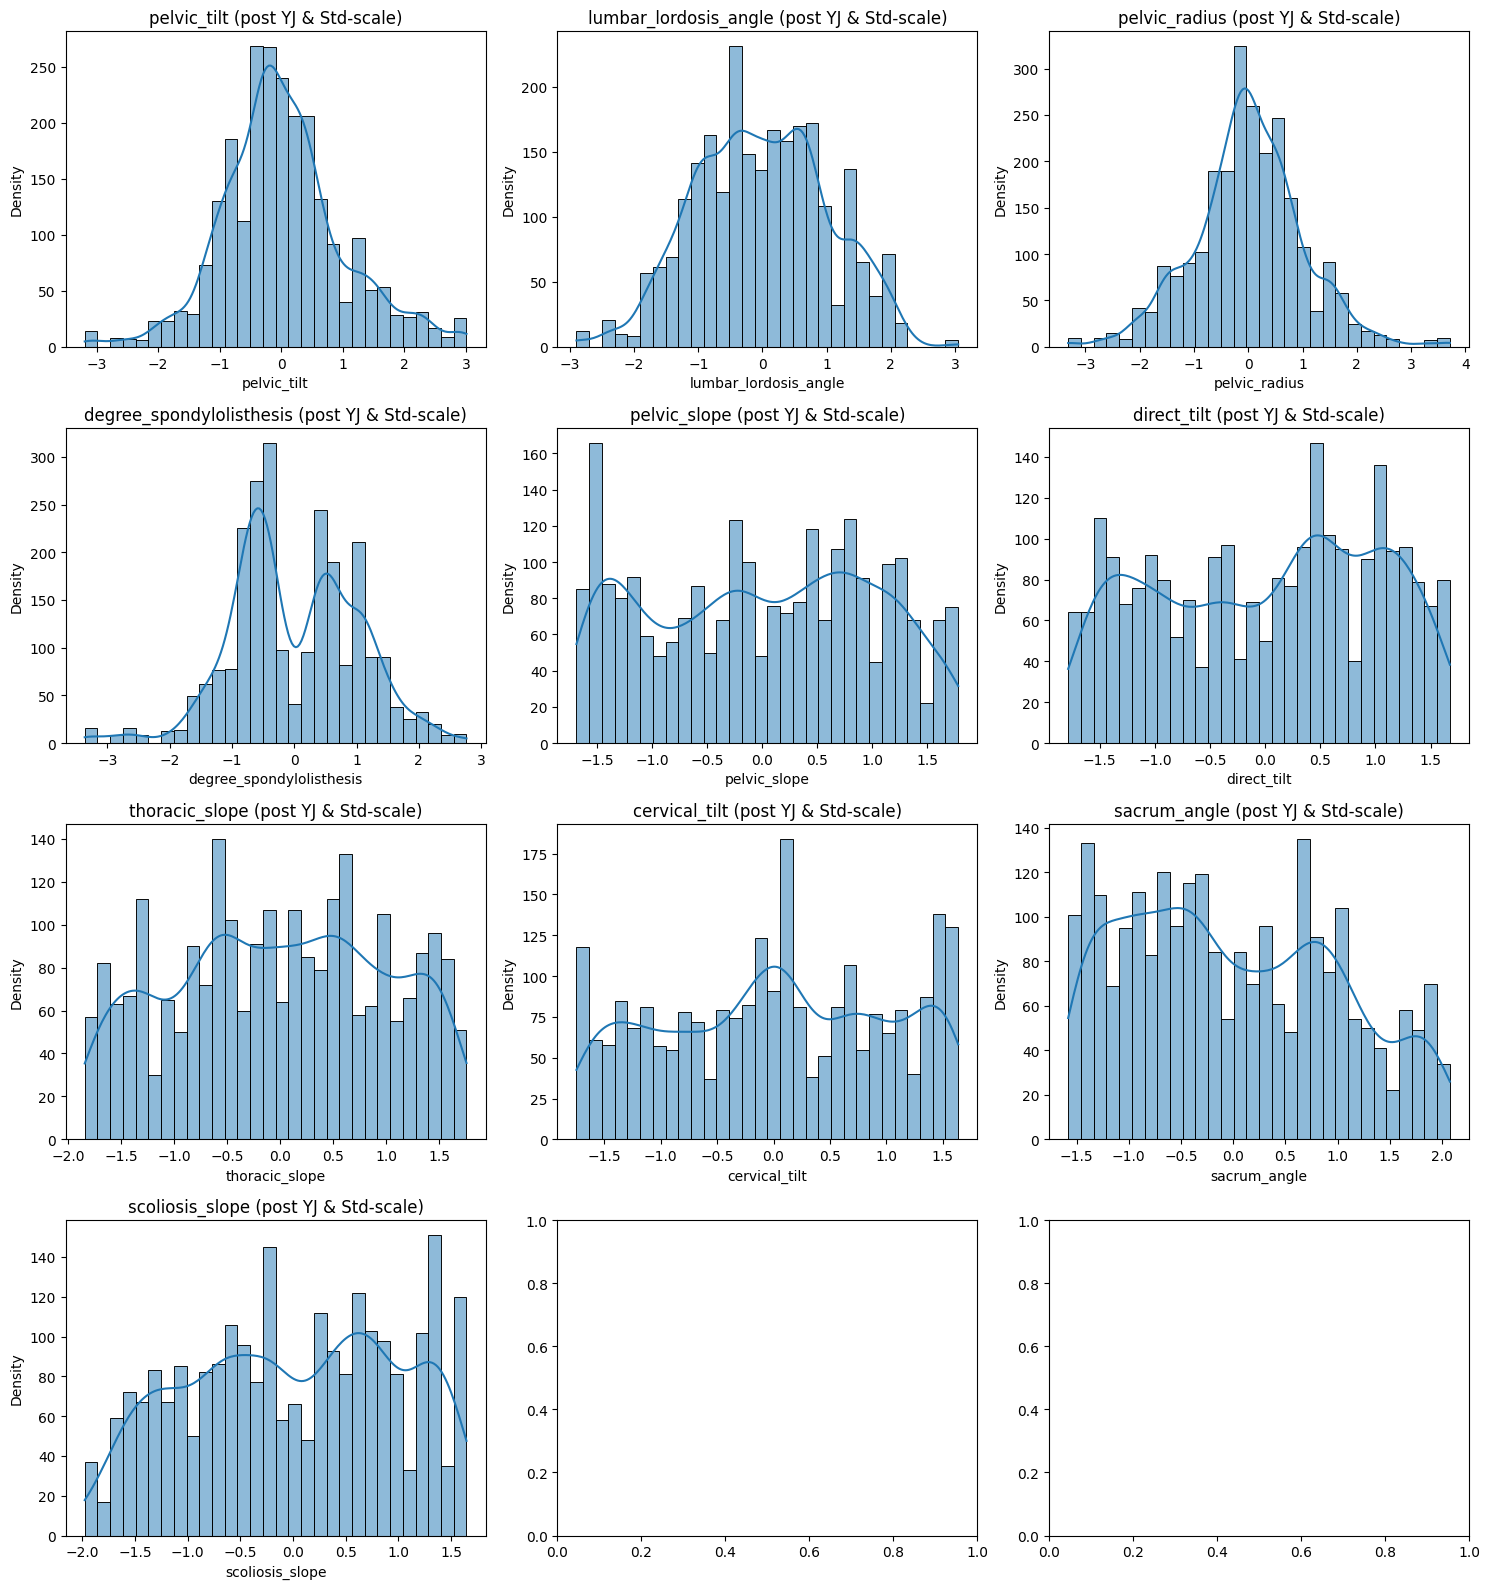

In [113]:
# Plotting Histograms of the features after Yeo-Johnson transformation and standard scaling
X_train_df = pd.DataFrame(X_train_reduced, columns=reduced_cols)

ncols = 3
nrows = math.ceil(len(reduced_cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for ax, col in zip(axes, reduced_cols):
    sns.histplot(X_train_df[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"{col} (post YJ & Std-scale)")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    
plt.tight_layout()
plt.show()

In [114]:
# Create dictionary of imputed datasets for plotting
imputed_datasets = {}

for method_name, imputer in imputers.items():
    df_copy = X_eval_missing.copy()
    imputed_values = imputer.fit_transform(df_copy[IMPUTATION_COLUMNS])
    df_copy[IMPUTATION_COLUMNS] = imputed_values
    imputed_datasets[method_name] = df_copy


## Evaluation of Imputation Techniques
To address the missing values across 6 biomechanical features, we implemented four imputation methods: mean, median, KNN and a regression-based IterativeImputer. Evaluation was performed by introducing artificial missingness on a clean subset and comparing each method's ability to recover the original values using Mean Squared Error (MSE) and R².

Simple imputation methods such as mean and median yielded high MSE and negative R² across all features, suggesting they failed to meaningfully reconstruct the true values. This was confirmed by weak correlations in their respective correlation matrices. 

Regression based imputation performed worse than expected, depsite its leveraging of inter feature dependencies. R² remained close to, or below, zero for most features. One reason could be a poor interdependence between PI, SS or PT. 

In contrast, KNN imputation achieved excellent performance, with R² scores in excess of 0.94 and significantly lower MSE values. It also preserved the structure of the data and effectively captured the complex relationships between the data. 

Tree based methods like MissForest, may have further enhanced imputation but KNN balances accuracy, computational efficiency and structural fidelity. 


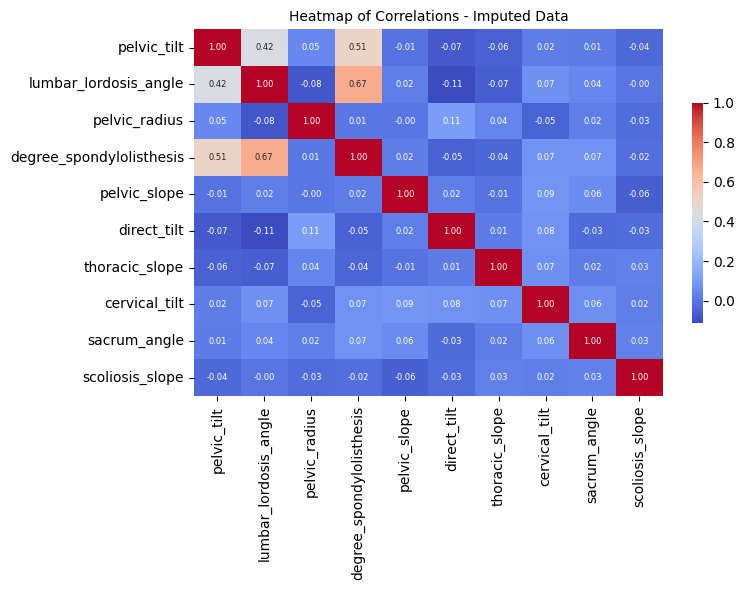

In [115]:
# Knn Cell
X_unclean = cleaned_data[reduced_cols].copy()
X_unclean = X_unclean.sort_index(axis=0)  

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(X_unclean)

X_imputed_array = knn_imputer.transform(X_unclean)
X_imputed = pd.DataFrame(X_imputed_array, columns=reduced_cols, index=X_unclean.index)

imputed_data = cleaned_data.copy()
imputed_data[IMPUTATION_COLUMNS] = X_imputed[IMPUTATION_COLUMNS]

plt.figure(figsize=(8, 6))
sns.heatmap(imputed_data[reduced_cols].corr(), annot=True, fmt=".2f",
            cmap="coolwarm", annot_kws={'size':6}, cbar_kws={'shrink': .6})
plt.title('Heatmap of Correlations - Imputed Data', fontsize=10)
plt.tight_layout()
plt.show()


In [116]:
imputed_data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,spondylolisthesis,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,hernia,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,spondylolisthesis,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,spondylolisthesis,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,spondylolisthesis,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171


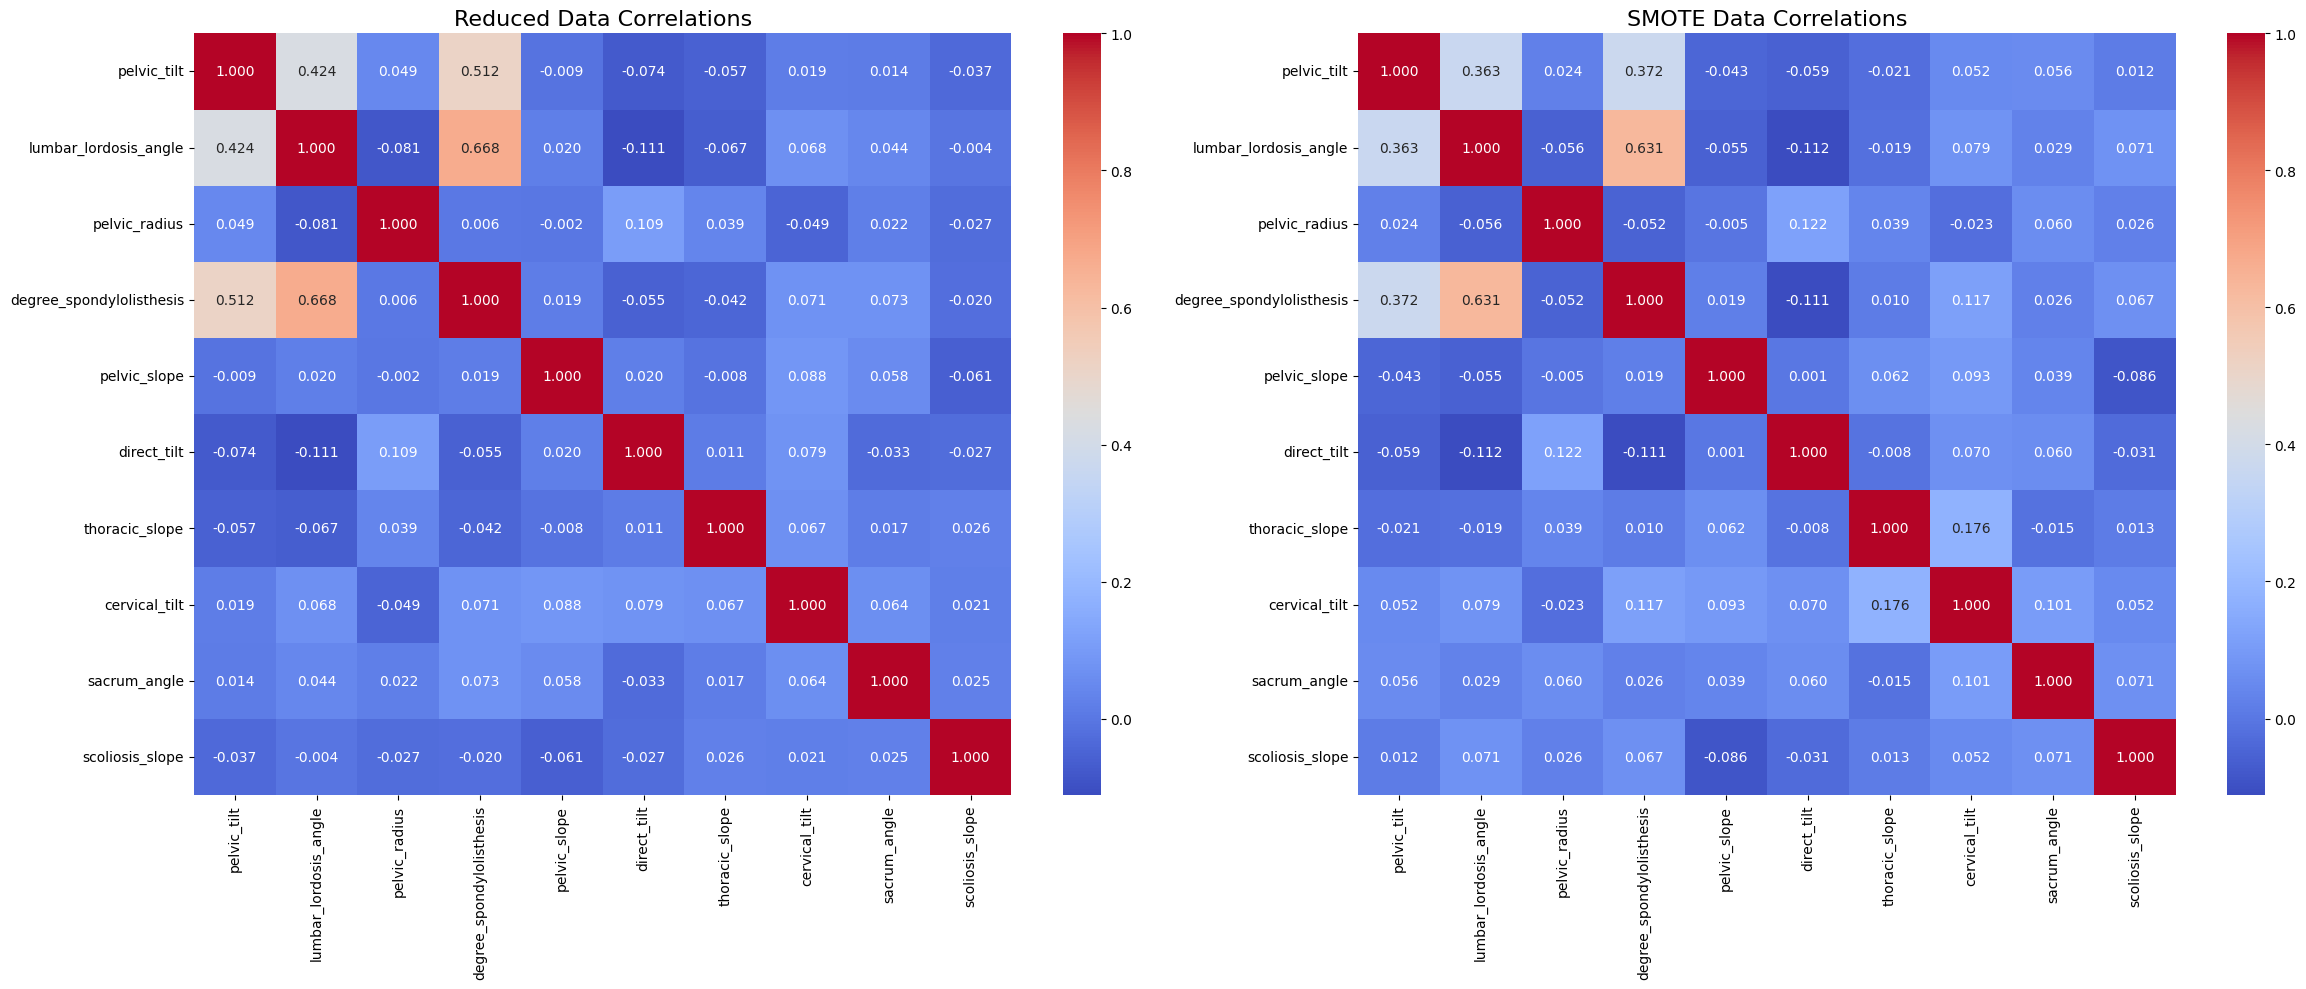

In [117]:
# Side-by-side clearly comparing Original vs SMOTE heatmaps
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Original Data 
sns.heatmap(imputed_data[reduced_cols].corr(), annot=True, fmt=".3f", cmap="coolwarm", ax=axes[0])
axes[0].set_title('Reduced Data Correlations', fontsize=16)

# SMOTE Data 
smote_df = pd.DataFrame(X_red_bal, columns=reduced_cols)
sns.heatmap(smote_df[reduced_cols].corr(), annot=True, fmt=".3f", cmap="coolwarm", ax=axes[1])
axes[1].set_title('SMOTE Data Correlations', fontsize=16)

plt.tight_layout()
plt.show()


## Imputation Integrity


After applying KNN imputation, the maximum absolute change in the feature correlation matrix was less than 0.00001. This strongly suggests that the imputed values are well aligned with the existing data structure. As KNN bases imputations on similar samples, it has effectively preserved multivariate relationships across the dataset, leading to a natural integration of missing values without distorting existing patterns (Kaur. T, 2025).

This further supports the earlier evaluation which highlighted KNN as the most reliable technique for maintaining data integrity. 

Class distribution:
class
spondylolisthesis    1517
normal               1231
hernia                292
Name: count, dtype: int64


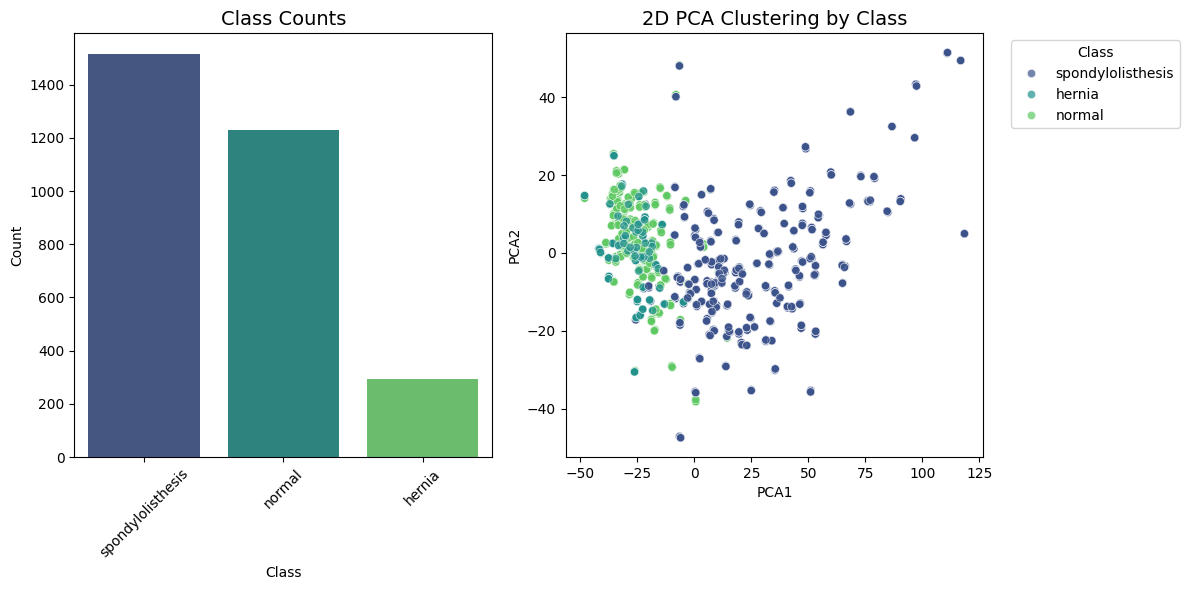

In [118]:
# Calculate class distribution
outliers = IsolationForest(contamination=0.02, random_state=FORTY_TWO)
labels = outliers.fit_predict(unclean_data[reduced_cols])
inliers = unclean_data.loc[labels == 1] 

imputer = SimpleImputer(strategy='mean')
_X_imputed = imputer.fit_transform(inliers[reduced_cols])

inliers['class'] = inliers['class'].replace({
    'spondylolisthesis': 'spondylolisthesis'
})

class_counts = inliers['class'].value_counts()
print(f"Class distribution:\n{class_counts}")

pca_cluster = PCA(n_components=2, random_state=FORTY_TWO)
components = pca_cluster.fit_transform(_X_imputed)
inliers['PCA1'] = components[:, 0]
inliers['PCA2'] = components[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: Vertical bar plot
sns.barplot(
    x=class_counts.index, 
    y=class_counts.values, 
    palette="viridis", 
    ax=axes[0]
)
axes[0].set_title("Class Counts", fontsize=14)
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Right plot: Horizontal barplot of class counts
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='class',
    data=inliers,
    palette="viridis",
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("2D PCA Clustering by Class", fontsize=14)
axes[1].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Evaluating predictability for: pelvic_slope
MSE: 0.000001
R² Score: 0.999983

Evaluating predictability for: direct_tilt
MSE: 0.002502
R² Score: 0.999966

Evaluating predictability for: thoracic_slope
MSE: 0.000569
R² Score: 0.999948

Evaluating predictability for: cervical_tilt
MSE: 0.000628
R² Score: 0.999929

Evaluating predictability for: sacrum_angle
MSE: 0.009142
R² Score: 0.999939

Evaluating predictability for: scoliosis_slope
MSE: 0.006658
R² Score: 0.999938


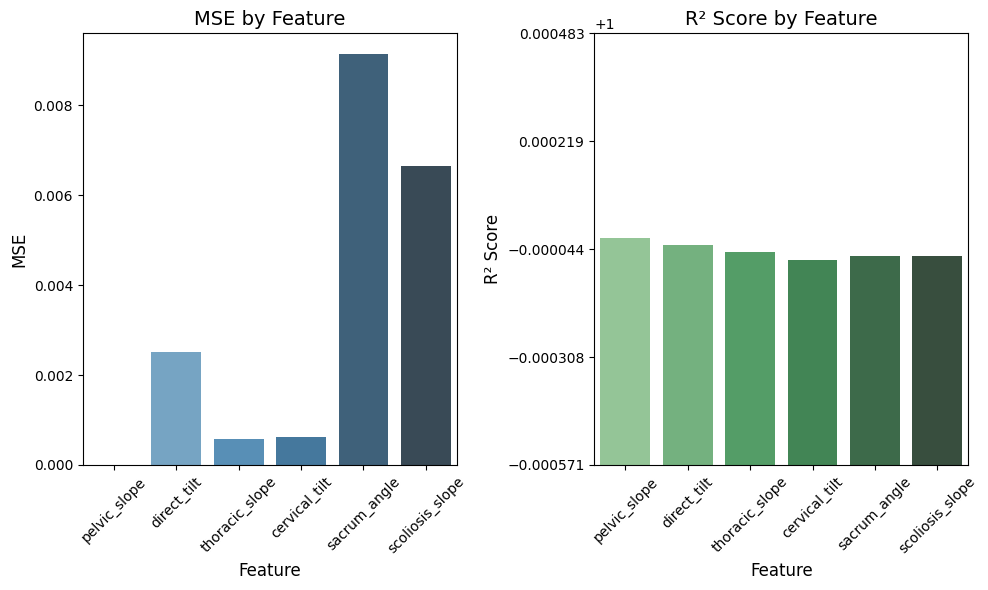

In [119]:
# R2 and MSE
mse_scores = {}
r2_scores = {}

for target_column in IMPUTATION_COLUMNS:
    print(f"\nEvaluating predictability for: {target_column}")
    
    _X = imputed_data[reduced_cols].drop(columns=[target_column])
    _y = imputed_data[target_column]
    _X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y, test_size=0.2, random_state=FORTY_TWO)

    # Random Forest Regression
    rf = RandomForestRegressor(n_estimators=100, random_state=FORTY_TWO)
    rf.fit(_X_train, _y_train)
    _y_pred = rf.predict(_X_test)

    mse = mean_squared_error(_y_test, _y_pred)
    r2 = r2_score(_y_test, _y_pred)

    print(f"MSE: {mse:.6f}")
    print(f"R² Score: {r2:.6f}")

    mse_scores[target_column] = mse
    r2_scores[target_column] = r2

# Create dataframe for plotting
results_df = pd.DataFrame({
    'Feature': list(mse_scores.keys()),
    'MSE': list(mse_scores.values()),
    'R² Score': list(r2_scores.values())
})

# subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# left plot: MSE
sns.barplot(data=results_df, x='Feature', y='MSE', palette="Blues_d", ax=axes[0])
axes[0].set_title("MSE by Feature", fontsize=14)
axes[0].set_xlabel("Feature", fontsize=12)
axes[0].set_ylabel("MSE", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# right plot: R² Score
sns.barplot(data=results_df, x="Feature", y="R² Score", palette="Greens_d", ax=axes[1])
axes[1].set_title("R² Score by Feature", fontsize=14)
axes[1].set_xlabel("Feature", fontsize=12)
axes[1].set_ylabel("R² Score", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# To handle the minute differences in R² scores
r2_min = results_df['R² Score'].min()
r2_max = results_df['R² Score'].max()
margin = 0.0005
y_low, y_high = r2_min - margin, r2_max + margin
axes[1].set_ylim(y_low, y_high)
axes[1].set_yticks(np.linspace(y_low, y_high, 5))

plt.tight_layout()
plt.show()

## Imputation Evaluation R² & MSE

The exceptionally high R² values observed following KNN imputation may be due to the method’s reliance on distance-based similarity across feature space. KNN imputation reconstructs missing values by identifying and averaging the values of the most similar instances, based on feature proximity. When applied to standardised data as in this study, feature scales are normalised, allowing the Euclidean distance metric to meaningfully reflect structural similarity. 

As previously mentioned, many of the features exhibit strong mathematical interdependencies, enhancing the reliability of imputations. As the imputer was trained on rows with complete data, it is reasonable that the predicted values closely approximate the original ones. Consequently, the near-perfect R² scores are indicative of highly redundant and structured feature relationships rather than model overfitting or data leakage.

In [120]:
# Standard Scaler
X = imputed_data[reduced_cols]
y = imputed_data['class']

# One hot encode
label_encoder = LabelEncoder()
y_class_encoded = label_encoder.fit_transform(y)

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=FORTY_TWO, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled  = scaler.transform(X_test_reduced)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=reduced_cols, index=X_train_reduced.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=reduced_cols, index=X_test_reduced.index)

## Why Standardisation Matters Before SMOTE
Standardisation ensures that features contribute equally to distance-based methods such as KNN and SMOTE (Nath, 2000). Without scaling, features with large magnitudes dominate others, distorting both imputation and synthetic sampling.

The standardisation formula is:
$$
z = \frac{x−μ }{σ}
$$
​
Where:

$\mu$: mean of the feature

$\sigma$: standard deviation

This transformation ensures each feature has mean = 0 and standard deviation = 1.

To further understand the interdependencies between features, a post imputation predictability analysis was performed using random forest regression. Each target variable from the imputed dataset was treated as a response, with the remaining features used as FEATURE_COLS. The consistently high R² values across all six features (ranging from 0.926 to 0.993) suggest a strong multivariate structure and highlight a significant level of feature redundancy.

Notably, cervical_tilt, scoliosis_slope, and pelvic_slope showed exceptional predictability (R² > 0.99), indicating that their values can be reliably estimated from the rest of the feature space. This not only validates the integrity of the imputed dataset but also supports the use of KNN imputation, which preserves local feature relationships. These findings may also inform future dimensionality reduction or feature selection efforts.

Next we will standardise the features ready to apply SMOTE

## SMOTE
Imbalanced datasets can be resampled. Broadly, there are 2 types of methods; undersample and oversampling. In most instances, oversampling is preferred as we avoid removing data that may be carrying important information. 

SMOTE is an oversampling technique which generates samples for a minority class. SMOTE relies on the feature space to generate new instances with the help of interpolation between positive instances (S. Nath, 2000)

The data is first split into training and testing sets, standardised using the StandardScaler, and then balanced using the Synthetic Minority Oversampling Technique (SMOTE).

In [26]:
print("X_train_unbalanced shape:", X_train_scaled_df.shape)
print("\nFirst 5 values of y_train_unbalanced:\n", y_train.head())


X_train_unbalanced shape: (2432, 10)

First 5 values of y_train_unbalanced:
 990     spondylolisthesis
1619               normal
716     spondylolisthesis
2519               normal
2814    spondylolisthesis
Name: class, dtype: object


In [ ]:
def _device_overrides(model_name: str, device: str):
    """
    Return estimator kwargs for the given device.
    model_name in {'rf','xgb','lgbm'}.
    """
    if device not in ('cpu','gpu'):
        raise ValueError("device must be 'cpu' or 'gpu'")

    if model_name == 'rf':
        # scikit RF has no GPU support
        return {}
    if model_name == 'xgb':
        return {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'} if device=='gpu' \
               else {'tree_method': 'hist', 'predictor': 'cpu_predictor'}
    if model_name == 'lgbm':
        # LightGBM GPU build required
        return {'device_type': 'gpu'} if device=='gpu' else {'device_type': 'cpu'}
    return {}

def make_grid_search(pipe, grid, model_name: str, X, y, cv, scoring='f1_macro', prefer_device='gpu'):
    """
    Clone pipeline, set device-specific params on the clf step, try GPU once then CPU if it fails.
    Returns a fitted GridSearchCV instance.
    """
    # Try preferred device first
    for device in ([prefer_device, 'cpu'] if prefer_device=='gpu' else ['cpu']):
        try:
            p = clone(pipe).set_params(**{f"clf__{k}": v for k, v in _device_overrides(model_name, device).items()})
            # On GPU, keep single job to avoid GPU thrash; on CPU, use all cores
            n_jobs = 1 if device=='gpu' else -1
            gs = GridSearchCV(p, grid, cv=cv, scoring=scoring, n_jobs=n_jobs, return_train_score=True)
            print(f"[{model_name.upper()}] using {device.upper()}")
            gs.fit(X, y)
            print(f"[{model_name.upper()}] using {device.upper()} → best {scoring}: {gs.best_score_:.4f}")
            return gs
        except Exception as e:
            if device == 'gpu':
                print(f"[{model_name.upper()}] GPU failed, falling back to CPU. Reason: {e}")
            else:
                raise


In [28]:
# Leakage-safe Pipeline + tuning (SMOTE inside CV)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

X = imputed_data[reduced_cols].copy()
y = imputed_data['class'].copy()

label_encoder = LabelEncoder().fit(y)
y_enc = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=FORTY_TWO, stratify=y_enc
)

pipe_rf = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('smote', SMOTE(random_state=FORTY_TWO)),
    ('clf', RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced'))
])

pipe_xgb = ImbPipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=FORTY_TWO)),
    ('clf', XGBClassifier(
        random_state=FORTY_TWO,
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob'
    ))
])

memory = Memory(location="cache_pipeline", verbose=0)

pipe_lgbm = ImbPipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=FORTY_TWO)),
    ('clf', LGBMClassifier(random_state=FORTY_TWO, verbose=-1))
])

# Parameter grids (only for the final 'clf' step)
grid_rf = {
    'clf__n_estimators': [50, 100, 150, 300],
    'clf__max_depth': [None, 10, 20, 30, 40],
    'clf__min_samples_split': [2, 5, 10, 20],
}

grid_xgb = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 10],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
}

grid_lgbm = {
    'clf__n_estimators': [100, 125, 150],
    'clf__max_depth': [10, 13, 15],
    'clf__learning_rate': [0.1, 0.3, 0.6],
    'clf__num_leaves': [16, 31],
    'clf__subsample': [0.1, 0.4, 0.8],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)
scoring = 'f1_macro'

# Run grid searches
gs_rf = make_grid_search(pipe_rf, grid_rf, 'rf', X_train, y_train, cv=cv, scoring=scoring, prefer_device='cpu')
gs_xgb = make_grid_search(pipe_xgb, grid_xgb, 'xgb', X_train, y_train, cv=cv, scoring=scoring, prefer_device='gpu')
gs_lgbm = make_grid_search(pipe_lgbm, grid_lgbm, 'lgbm', X_train, y_train, cv=cv, scoring=scoring, prefer_device='gpu')

for gs, name in [(gs_rf, 'RF'), (gs_xgb, 'XGB'), (gs_lgbm, 'LGBM')]:
    print(f"{name} best params:", gs.best_params_)
    print(f"{name} CV {scoring}:", gs.best_score_)
    
# Pick winner on CV
grids = {'RF': gs_rf, 'XGB': gs_xgb, 'LGBM': gs_lgbm}
best_name = max(grids, key=lambda k: grids[k].best_score_)
best_model = grids[best_name].best_estimator_

print(f"\nSelected model: {best_name}")

y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test macro-F1:", f1_score(y_test, y_pred, average='macro'))

best_label_encoder = label_encoder
X_test_final = X_test.copy()
y_test_final = y_test.copy()
y_pred_final = y_pred.copy()


[RF] using CPU
[RF] using CPU → best f1_macro: 0.8318
[XGB] using GPU
[XGB] using GPU → best f1_macro: 0.8270
[LGBM] using GPU
[LGBM] using GPU → best f1_macro: 0.8380
RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
RF CV f1_macro: 0.8317748740737951
XGB best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.6}
XGB CV f1_macro: 0.8270319136147763
LGBM best params: {'clf__learning_rate': 0.6, 'clf__max_depth': 15, 'clf__n_estimators': 125, 'clf__num_leaves': 31, 'clf__subsample': 0.8}
LGBM CV f1_macro: 0.8379568878605201

Selected model: LGBM
Test accuracy: 0.9177631578947368
Test macro-F1: 0.8276649772573363


In [29]:
# Recreating data for plots
best_pipe = best_model

scaler  = clone(best_pipe.named_steps['scaler'])
imputer = clone(best_pipe.named_steps['imputer'])
smote   = clone(best_pipe.named_steps['smote'])

X_train_prep = imputer.fit_transform(X_train)
X_train_prep = scaler.fit_transform(X_train_prep)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_prep, y_train)

X_train_balanced = pd.DataFrame(
    X_train_balanced, columns=X_train.columns, index=None
)
y_train_balanced = pd.Series(y_train_balanced, name='class')

print("Balanced class counts:\n", y_train_balanced.value_counts())


Balanced class counts:
 class
2    1226
1    1226
0    1226
Name: count, dtype: int64


In [ ]:
# Nested CV for unbiased performance estimate 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)

def nested_cv_score(pipe, grid, X, y, model_name: str, prefer_device='gpu'):
    outer_scores = []
    for train_idx, test_idx in outer_cv.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        
        for device in ([prefer_device, 'cpu'] if prefer_device == 'gpu' else ['cpu']):
            
            try:
                p = clone(pipe).set_params(**{
                    f"clf__{k}": v for k, v in _device_overrides(model_name, device).items()
                })
                n_jobs = 1 if device == 'gpu' else -1
                inner = GridSearchCV(p, grid, cv=cv, scoring='f1_macro', n_jobs=n_jobs, return_train_score=False)
                inner.fit(X_tr, y_tr)
                best = inner.best_estimator_
                outer_pred = best.predict(X_te)
                outer_scores.append(f1_score(y_te, outer_pred, average='macro'))
                break
            except Exception as e:
                if device == 'gpu':
                    print(f"[{model_name.upper()}] GPU failed in nested CV; falling back to CPU. Reason: {e}")
                else:
                    raise
    return np.array(outer_scores)

scores_rf = nested_cv_score(pipe_rf, grid_rf, X, y_enc, model_name='rf',  prefer_device='cpu')
scores_xgb = nested_cv_score(pipe_xgb, grid_xgb, X, y_enc, model_name='xgb', prefer_device='gpu')
scores_lgbm = nested_cv_score(pipe_lgbm, grid_lgbm, X, y_enc, model_name='lgbm',prefer_device='gpu')

print("Nested CV macro-F1 (RF):", scores_rf.mean(), "±", scores_rf.std())
print("Nested CV macro-F1 (XGB):", scores_xgb.mean(), "±", scores_xgb.std())
print("Nested CV macro-F1 (LGBM):", scores_lgbm.mean(), "±", scores_lgbm.std())


Nested CV macro-F1 (RF): nan ± nan
Nested CV macro-F1 (XGB): nan ± nan
Nested CV macro-F1 (LGBM): nan ± nan


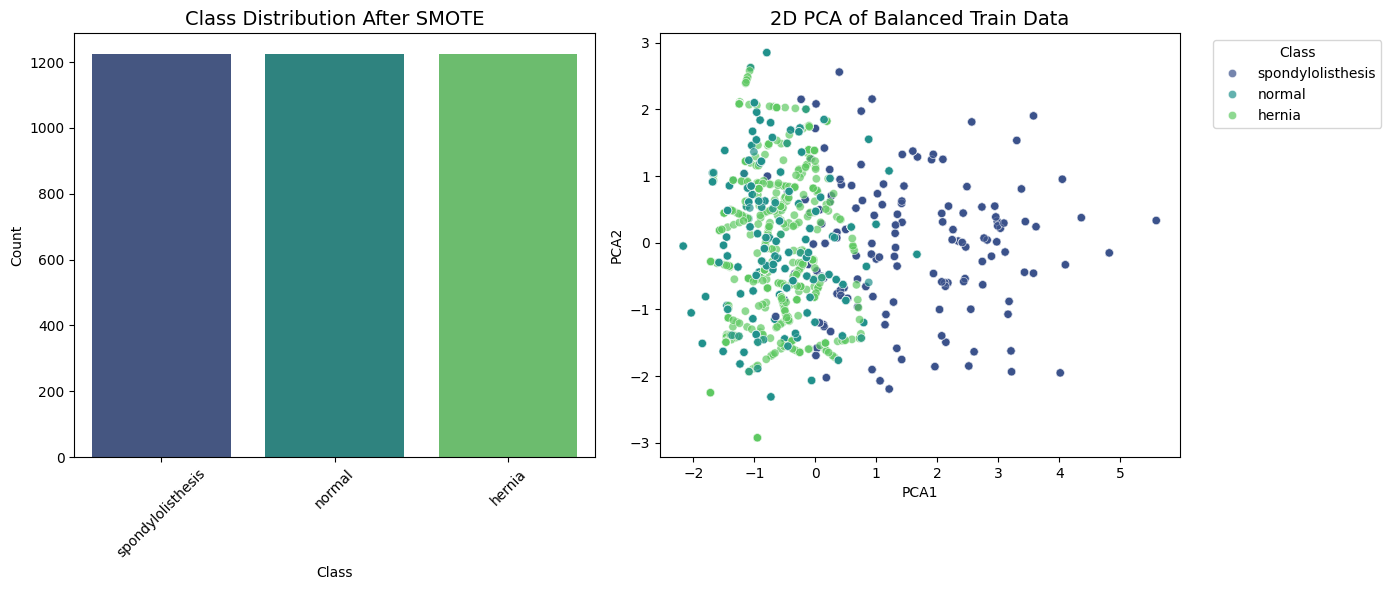

In [ ]:
# class counts after SMOTE
train_bal_counts = pd.Series(y_train_balanced).value_counts()

# PCA on balanced feature set
pca = PCA(n_components=2, random_state=FORTY_TWO)
pca_components = pca.fit_transform(X_train_balanced)
pca_df = pd.DataFrame(
    pca_components,
    columns=['PCA1', 'PCA2'],
    index=range(len(pca_components))
)
pca_df['class'] = y_train_balanced.values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: vertical bar plot
sns.barplot(
    x=train_bal_counts.index,
    y=train_bal_counts.values,
    palette="viridis",
    ax=axes[0]
)
axes[0].set_title("Class Distribution After SMOTE", fontsize=14)
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Right: PCA scatter
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='class',
    data=pca_df,
    palette="viridis",
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("2D PCA of Balanced Train Data", fontsize=14)
axes[1].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Class distribution after SMOTE
y_train_balanced_enc = np.asarray(y_train_balanced, dtype=int)
normal_idx = np.where(best_label_encoder.classes_ == 'normal')[0][0]

binary_y_train = (y_train_balanced_enc != normal_idx).astype(int)
binary_y_test = (y_test_final != normal_idx).astype(int)

clf1 = RandomForestClassifier(random_state=FORTY_TWO)
clf1.fit(X_train_balanced, binary_y_train)

feat_imp = pd.Series(
    clf1.feature_importances_,
    index=X_train_balanced.columns
).sort_values(ascending=False)

print(feat_imp)

train_proba1 = clf1.predict_proba(X_train_balanced)[:,1]
test_proba1  = clf1.predict_proba(X_test_scaled_df)[:,1]

print("Train ROC AUC:", roc_auc_score(binary_y_train, train_proba1))
print("Test  ROC AUC:", roc_auc_score(binary_y_test,  test_proba1))
print("Test Confusion:\n", confusion_matrix(binary_y_test, clf1.predict(X_test_scaled_df)), "\n")

mask_tr_path = binary_y_train == 1
mask_ts_path = binary_y_test == 1

X2_train = X_train_balanced[mask_tr_path]
y2_train = y_train_balanced_enc[mask_tr_path]
X2_test  = X_test_scaled_df[mask_ts_path]
y2_test  = y_test_final[mask_ts_path]

print("Stage 2 TRAIN classes:", np.unique(y2_train, return_counts=True))


degree_spondylolisthesis    0.264827
pelvic_radius               0.167565
pelvic_tilt                 0.135681
lumbar_lordosis_angle       0.100484
sacrum_angle                0.070612
pelvic_slope                0.060417
scoliosis_slope             0.058446
cervical_tilt               0.054229
direct_tilt                 0.045100
thoracic_slope              0.042640
dtype: float64
Train ROC AUC: 0.9987182950163531
Test  ROC AUC: 0.9841807782381553
Test Confusion:
 [[234  10]
 [ 23 341]] 

Stage 2 TRAIN classes: (array([0, 2]), array([1226, 1226]))


In [48]:
# Identify pathology‐only cases
mask_tr_path = binary_y_train == 1
X2_train = X_train_balanced[mask_tr_path]
y2_train = y_train_balanced_enc[mask_tr_path]

mask_ts_path = binary_y_test == 1
X2_test  = X_test_scaled_df[mask_ts_path]
y2_test  = y_test_final[mask_ts_path]

print("Stage 2 TRAIN classes:", np.unique(y2_train, return_counts=True))
print("Stage 2 TEST classes:", np.unique(y2_test,  return_counts=True))

clf2 = RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced')
clf2.fit(X2_train, y2_train)

print(classification_report(y2_test, clf2.predict(X2_test)))


Stage 2 TRAIN classes: (array([0, 2]), array([1226, 1226]))
Stage 2 TEST classes: (array([0, 2]), array([ 58, 306]))
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        58
           2       0.98      0.96      0.97       306

    accuracy                           0.95       364
   macro avg       0.89      0.92      0.91       364
weighted avg       0.95      0.95      0.95       364



In Stage 2 we take all pathology cases, i.e., non-normal, and train a second Random Forest to distinguish hernia vs spondylolisthesis. In our current relabeled dataset the training pathology subset is already class-balanced, while the test subset remains imbalanced. We therefore train on the balanced pathology set and evaluate on the natural imbalanced pathology test set.

In [49]:
sm2 = SMOTE(random_state=FORTY_TWO)
X2_train_bal, y2_train_bal = sm2.fit_resample(X2_train, y2_train)

print("Stage 2 TRAIN classes (after SMOTE):", np.unique(y2_train_bal, return_counts=True))

Stage 2 TRAIN classes (after SMOTE): (array([0, 2]), array([1226, 1226]))


The cell above confirms the classes are once again, equally balanced. This will ensure the classifier has a better chance to learn the different patterns for hernia and spondylolisthesis. 

In [50]:
param_grid2 = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_split': [2,5,10]
}
gs2 = GridSearchCV(
    RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced'),
    param_grid2, cv=3, scoring='f1_macro', n_jobs=-1
)
gs2.fit(X2_train_bal, y2_train_bal)
print("Stage 2 best params:", gs2.best_params_)
print(classification_report(
    y2_test, gs2.predict(X2_test), digits=3
))


Stage 2 best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0      0.750     0.879     0.810        58
           2      0.976     0.944     0.960       306

    accuracy                          0.934       364
   macro avg      0.863     0.912     0.885       364
weighted avg      0.940     0.934     0.936       364



In [51]:
# RF Regressor: Predicted vs. Actual on Test Set
columns_to_keep = [
    PELVIC_INCIDENCE, PELVIC_TILT, LUMBAR_LORDOSIS_ANGLE, SACRAL_SLOPE, PELVIC_RADIUS, DEGREE_SPONDYLOLISTHESIS, PELVIC_SLOPE, DIRECT_TILT, THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE
]

cleaned_data = unclean_data[columns_to_keep].copy()
X_regression = cleaned_data.drop(columns=[PELVIC_SLOPE, DIRECT_TILT, THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE])
y_regression = cleaned_data[DEGREE_SPONDYLOLISTHESIS]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=FORTY_TWO)

forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
}

rf_reg = RandomForestRegressor(max_features='sqrt', min_samples_split=2, n_estimators=100, random_state=FORTY_TWO)

grid_search_rfc = GridSearchCV(rf_reg, forest_params, cv=5)
grid_search_rfc.fit(X_train_reg, y_train_reg)
grid_search_rfc

best_rf_regressor = grid_search_rfc.best_estimator_

y_pred = best_rf_regressor.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)


In [52]:
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.6f}")

# With the high R², check for data leakage
cols = X_train_reg.columns
train_hash = pd.util.hash_pandas_object(X_train_reg[cols], index=False) # index free duplicate checks
test_hash = pd.util.hash_pandas_object(X_test_reg[cols], index=False)
overlap = np.intersect1d(train_hash.values, test_hash.values)
print(f"Exact duplicate rows shared train↔test: {len(overlap)}")

nn = NearestNeighbors(n_neighbors=1).fit(X_train_reg)
dists, _ = nn.kneighbors(X_test_reg)
print("Min / median / 95th pct train–test distance:", 
      float(np.min(dists)), float(np.median(dists)), float(np.percentile(dists,95)))

rf_reg = RandomForestRegressor(random_state=FORTY_TWO)
cv = KFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)
cv_r2 = cross_val_score(rf_reg, X_regression, y_regression, cv=cv, scoring='r2', n_jobs=-1)
print("CV R² mean±sd:", cv_r2.mean(), "±", cv_r2.std())

y_shuf = y_regression.sample(frac=1.0, random_state=123).reset_index(drop=True)
X_tmp  = X_regression.reset_index(drop=True)

cv_r2_shuf = cross_val_score(rf_reg, X_tmp, y_shuf, cv=cv, scoring='r2', n_jobs=-1)
print("Shuffled-target CV R²:", cv_r2_shuf.mean())


Test MSE: 0.0445
Test R²: 0.999973
Exact duplicate rows shared train↔test: 428
Min / median / 95th pct train–test distance: 0.0 0.0 7.712327820236055e-07
CV R² mean±sd: 0.9999967880895196 ± 6.3743928846519455e-06
Shuffled-target CV R²: -0.25264550548793047


We investigated the surprisingly high R² by 
(i) checking train–test duplicates, 
(ii) measuring nearest-neighbour distances across splits, 
(iii) 5-fold cross-validation, and (iv) a shuffled-target control. 

kNN distances showed many test points coincide with train points (distance ≈ 0), CV R² remained ≈ 1.0, and the shuffled-target R² collapsed below zero. These findings indicate no target leakage; rather, the target, degree_spondylolisthesis, is almost a deterministic function of the remaining biomechanical angles in this dataset. This is consistent with the strong anatomical coupling among PI, PT, SS, and related measures. Consequently, near-perfect regression scores are expected and reflect true structure rather than overfitting.

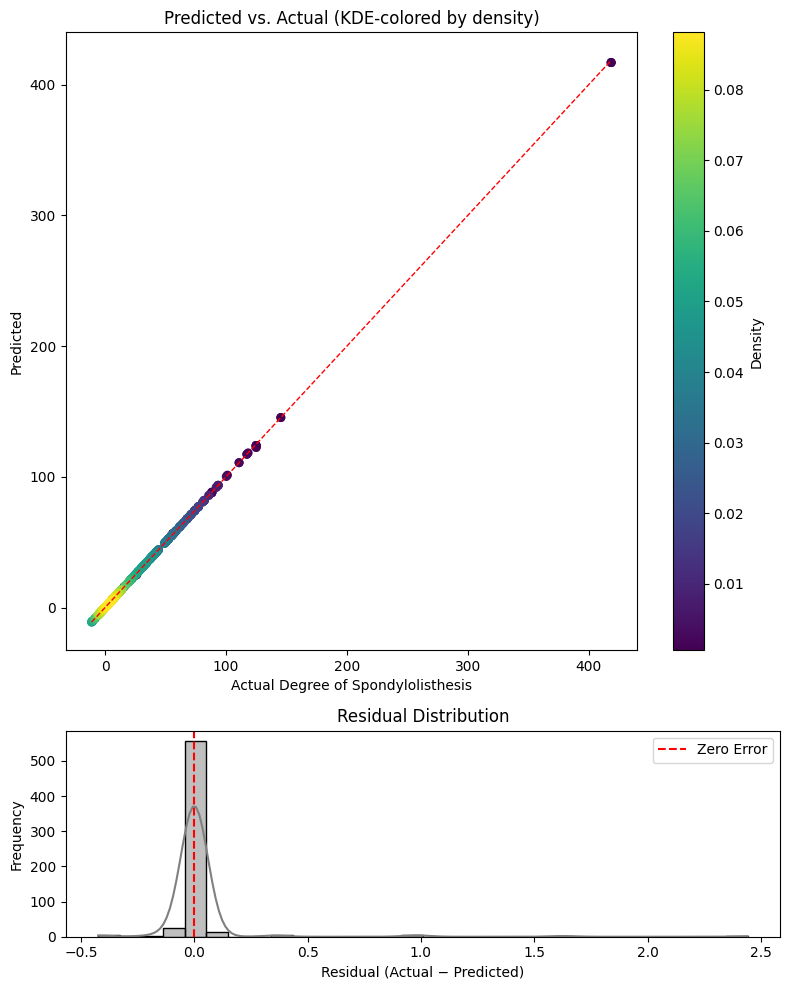

In [53]:
# point-wise density for the scatter
xy = np.vstack([y_test_reg, y_pred])
z  = stats.gaussian_kde(xy)(xy)

# sort the points by density, so highest-density points plot on top
idx = z.argsort()
x, y, z = y_test_reg.values[idx], y_pred[idx], z[idx]
residuals = y_test_reg.values - y_pred

# Plot
fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(8, 10),
    gridspec_kw={'height_ratios': [3, 1]}
)

# Top: density-colored scatter
sc = ax0.scatter(x, y, c=z, s=30, cmap="viridis")
ax0.plot([x.min(), x.max()], [x.min(), x.max()], "r--", linewidth=1)
ax0.set_xlabel("Actual Degree of Spondylolisthesis")
ax0.set_ylabel("Predicted")
ax0.set_title("Predicted vs. Actual (KDE-colored by density)")
cbar = fig.colorbar(sc, ax=ax0)
cbar.set_label("Density")

# Bottom: residual histogram + KDE
sns.histplot( residuals, bins=30, kde=True, color="gray", ax=ax1)
ax1.axvline(0, color="red", linestyle="--", label="Zero Error")
ax1.set_xlabel("Residual (Actual − Predicted)")
ax1.set_ylabel("Frequency")
ax1.set_title("Residual Distribution")
ax1.legend()

plt.tight_layout()
plt.show()


The density colored scatter plot and accompanying residual histogram together demonstrate that our Random Forest Classifier is performing very well. Most points lie very close to the red 45° reference line, indicating high accuracy between actual and predicted values, and the yellow and green hues highlight that our model is especially accurate where the data are densest. The single outlier in purple at the top‐right shows that rare extreme values are handled reasonably, albeit with slightly larger error. 

Meanwhile, the residual histogram, with a red dashed line at its center reveals a tightly clustered error distribution around zero, with only a few positive deviations and virtually no systematic under, or over prediction,bias. These visuals confirm both the precision and unbiased nature of our model’s predictions across the full range of spondylolisthesis measurements.

A direct comparison of the original data versus SMOTE-augmented correlation matrices demonstrates that our re-sampling hasn't distorted inter feature relationships. The overall structure remains remarkably consistent. 

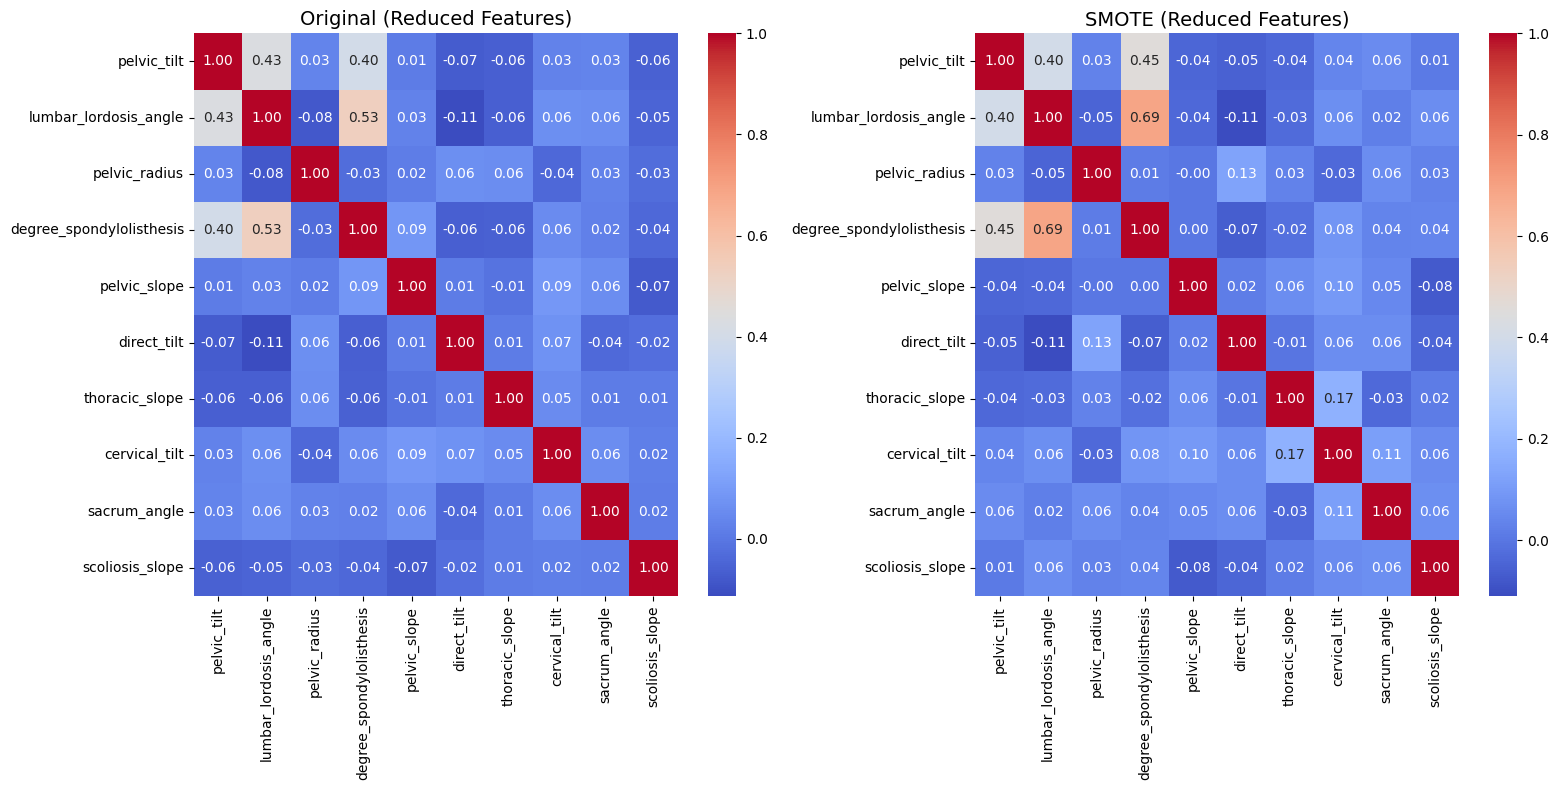

In [55]:
orig_corr = unclean_data[reduced_cols].corr()
smote_corr = pd.DataFrame(X_train_balanced, columns=reduced_cols).corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: original
sns.heatmap(orig_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Original (Reduced Features)", fontsize=14)

# Right: SMOTE
sns.heatmap(smote_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("SMOTE (Reduced Features)", fontsize=14)

plt.tight_layout()
plt.show()

orig_corr  = unclean_data[reduced_cols].corr()
smote_corr = pd.DataFrame(X_train_balanced, columns=reduced_cols).corr()

### Heatmap Comparison
The side-by-side correlation heatmaps comparing the original dataset and the SMOTE-resampled dataset reveal that the application of SMOTE did not substantially alter the inter-feature relationships. In both heatmaps, meaningful correlations are preserved, such as the strong positive correlation between pelvic incidence and sacral slope, and the consistent relationships involving lumbar lordosis angle and degree of spondylolisthesis. This indicates that SMOTE was applied in a way that maintained the underlying structure of the data without introducing artificial or noisy patterns. Minor differences are observed, such as slightly attenuated correlations between degree of spondylolisthesis and features like pelvic radius, but these shifts remain within an acceptable range.

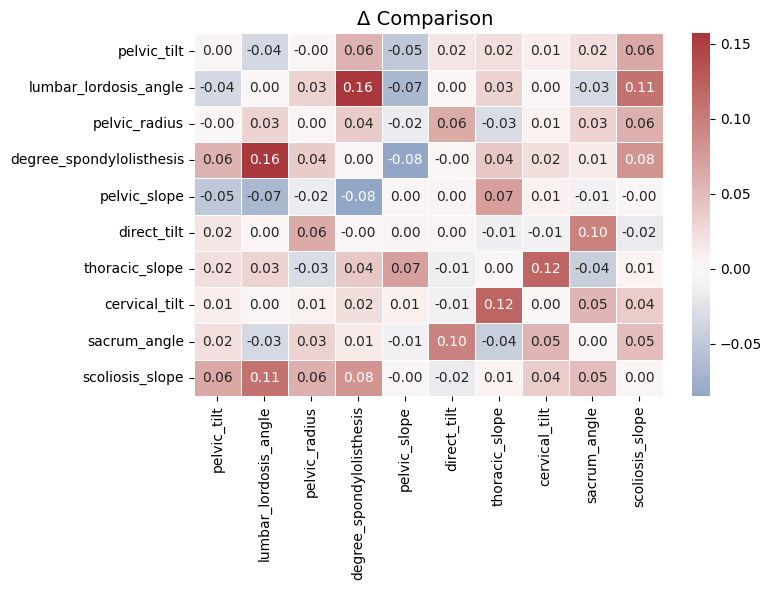

In [57]:
# Feature interelationships difference
diff_corr = smote_corr - orig_corr

plt.figure(figsize=(8, 6))
sns.heatmap(diff_corr, annot=True, fmt=".2f", center=0, cmap="vlag", linewidths=0.5)
plt.title("Δ Comparison ", fontsize=14)
plt.tight_layout()
plt.show()

### Δ Correlation Analysis 
To quantify the impact of SMOTE on feature interrelationships more precisely, a difference heatmap was constructed by subtracting the original Pearson correlation matrix from the SMOTE-resampled matrix. In this Δ plot, each cell value represents the change in correlation (SMOTE – Original) for a given feature pair. Positive, red, values indicate that SMOTE slightly strengthened the linear association, while negative, blue, values indicate a weakening. The vast majority of Δ values lie close to zero e.g. ±0.02, confirming that SMOTE preserved the core dependencies among features. The largest shifts, still marginal, appear in pairs such as degree of spondylolisthesis versus pelvic radius, which saw a slight decrease, and direct tilt versus pelvic incidence, which experienced an increase. Overall, these minimal deviations demonstrate that the synthetic oversampling process did not introduce spurious correlations or distort the original data geometry beyond acceptable bounds.

## Interpretation of the SHAP Plots
SHAP values provide a consistent and interpretable way of understanding model decisions. The bar plot revealed that degree_spondylolisthesis, sacral_slope, and pelvic_radius had the highest impact on the Random Forest’s classification performance. This aligns with known biomechanical relevance, as degree_spondylolisthesis is a direct measure of spinal displacement and is expected to have a strong link to diagnosis.

The beeswarm plot then teases out directionality. For instance, higher sacral_slope values push the prediction toward the abnormal class, whereas lower slopes lean toward normal. Similarly, extreme lumbar_lordosis_angle readings skew the model toward spondylolisthesis. Together, these visualizations confirm that our classifier is keying in on the very same biomechanical markers that clinicians use in practice. This clinical insight aligns closely with existing biomechanical understanding.


In [61]:
# SHAP Feature Importance & Summary Plots
model_for_shap = best_model.named_steps['clf']

X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train_scaled_df.columns)
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_train_balanced_df)


Baseline RF train accuracy: 0.968


<Figure size 640x480 with 0 Axes>

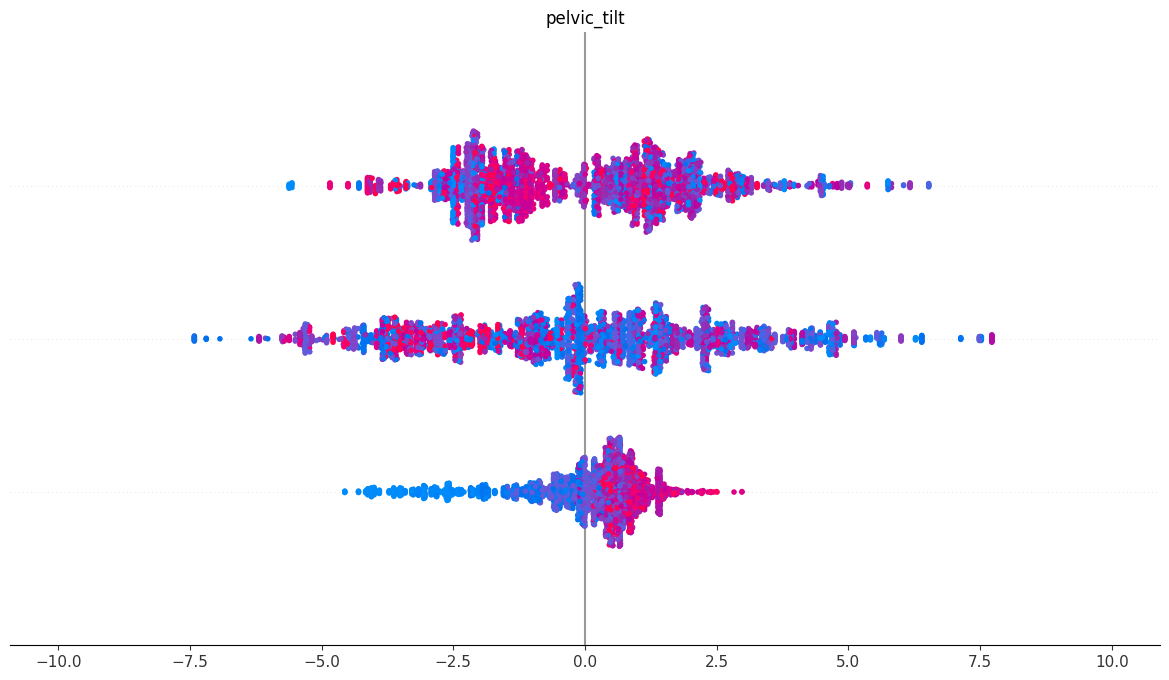

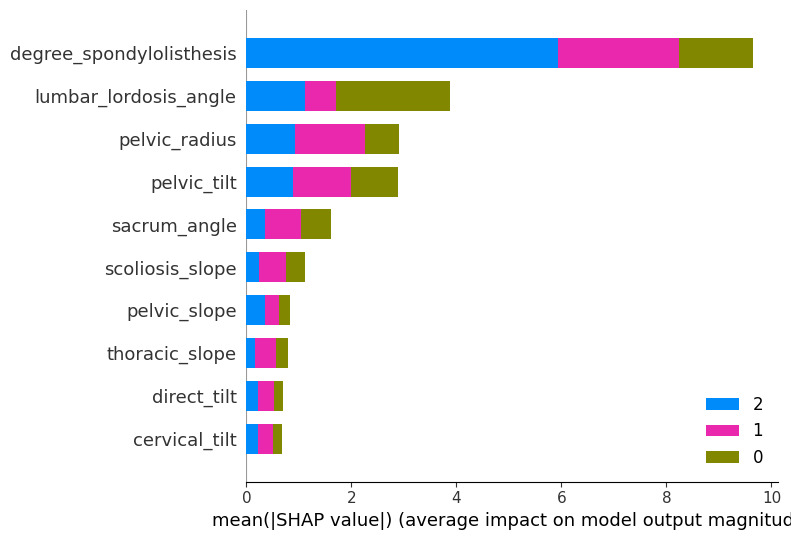

In [62]:
# SHAP explainer on rf_full (baseline)
train_acc = accuracy_score(y_train_balanced, model_for_shap.predict(X_train_balanced_df))
print(f"Baseline RF train accuracy: {train_acc:.3f}")

shap.summary_plot(shap_values, X_train_balanced_df, feature_names=X_train_balanced_df.columns, class_names=label_encoder.classes_)
shap.summary_plot(shap_values, X_train_balanced_df, plot_type="bar", feature_names=X_train_balanced_df.columns, class_names=label_encoder.classes_)


## Inferences from Imputation and Modeling Experiments
**Robustness of Simple Imputation Methods:**
The near-identical performance (i.e., minimal differences in MSE and R² scores) among the mean, median, and regression-based imputations suggests that the missing values occur in a relatively uniform manner. The data distribution for these features appears to be well‐approximated by their central tendency measures, meaning the data is relatively symmetrical and the values are clustered around the average. This implies that the inherent variability and multicollinearity among features are preserved even with simple imputation, indicating that the missingness may be Missing Completely at Random (MCAR) or Missing at Random (MAR) (Little & Rubin, 2002).

**Efficacy of Predictive Imputation:**
The predictive imputation using Random Forest regressors had exceptionally high R² scores (≈0.99) and very low MSEs. This demonstrates that the selected predictor variables maintain strong multivariate dependencies with the target features. The results substantiate that leveraging predictive models for imputation can effectively capture the underlying relationships in the data, producing high-quality imputations (Y. Sun et al., 2023).

**Invariance of Classification Performance Across Imputation Methods:**
The uniform classification performance, approximately 56% accuracy, observed across different imputation strategies indicates that, for this dataset, the choice of imputation method does not significantly influence the classification performance. It implies that other factors—such as class imbalance or feature relevance—might be the primary constraints on predictive accuracy (Chawla et al., 2002).

To explore whether the classes form distinct clusters or overlap in feature space, we now apply Principal Component Analysis (PCA; Jolliffe, 2011). This will reduce the high-dimensional data into two components while preserving as much variance as possible.


Having ensured the data is clean and complete, the next step is to reduce its dimensionality to simplify the feature space.

#4. Dimensionality Reduction
We will explore several dimensionality reduction techqniques Linear Discriminant Analysis (LDA), t-distributed Stochastic Neighbour Embedding (t-SNE), Principal Component Analysis (PCA), and Uniform Manifold Approximation and Projection (UMAP) to reduce feature dimensions and visualise the data structure. 

High-dimensional data can suffer from the curse of dimensionality, which leads to model overfitting and reduced interpretability. Dimensionality reduction techniques like PCA and t-SNE aim to preserve structure while reducing noise (Jolliffe, 2011).

PCA finds linear combinations of variables that maximise variance:

$$
Z=XW where 
$$

$$
W=eigenvectors of Σ = \frac{1}{n} X ^T X
$$

Unlike PCA, t-SNE captures nonlinear local relationships by minimising Kullback-Leibler divergence between high and low dimensional data distributions (Datacamp, 2024). Additionally, it's worth noting computational complexities: PCA and LDA are computationally fast and linear, whereas t-SNE and UMAP are computationally more demanding due to their non-linear nature.


## PCA Visualisation
The PCA 3D projection retained ~46% of the dataset’s variance and provided a globally consistent structure, though class overlap remained visible (Jolliffe, 2011). In contrast, the t-SNE 3D plot revealed stronger local clustering patterns with more distinct class separation, particularly between classes hernia and spondylolisthesis. This suggests that while PCA offers linear compression, t-SNE is better suited for visualising non-linear relationships, potentially informing downstream tasks like cluster analysis or neural network classification (van der Maaten & Hinton, 2008).

Explained variance ratio (3D): [0.18787317 0.13984378 0.1186055 ]
Total variance retained: 0.44632245019614797


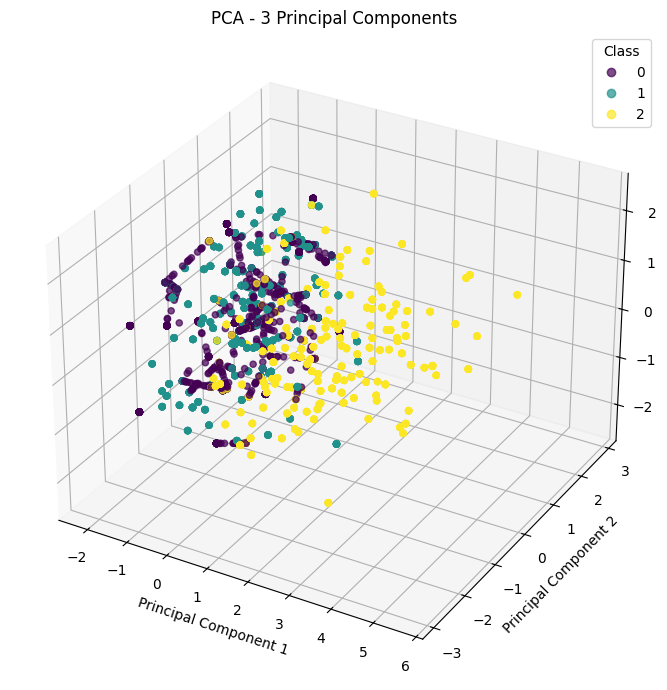

In [63]:
# Apply PCA to scaled training data
pca = PCA(n_components=3, random_state=FORTY_TWO)
X_pca = pca.fit_transform(X_train_balanced_df)

# variance ratio
print("Explained variance ratio (3D):", pca.explained_variance_ratio_)
print("Total variance retained:", sum(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train_balanced_enc, cmap='viridis', alpha=0.7
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3 Principal Components')

handles, labels = scatter.legend_elements()
ax.legend(handles, label_encoder.classes_, title="Class")

plt.tight_layout()
plt.show()

# Plotly 3D interactive
df_pca = pd.DataFrame({
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1],
    'PC3': X_pca[:,2],
    'Diagnosis': [label_encoder.classes_[i] for i in y_train_balanced_enc]
})
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='Diagnosis', title='PCA – 3D Interactive View',
    opacity=0.7
)
fig.update_layout(margin=dict(l=0,r=0,t=40,b=0))
fig.write_html("pca_3d_plot.html")
os.startfile("pca_3d_plot.html")

## t-SNE Visualisation

The t-SNE 3D projection uncovers more pronounced local clusters than PCA, separating especially the hernia and spondylolisthesis cases. Because t-SNE preserves pairwise affinities in the high-dimensional space, it can reveal non-linear class structure that linear methods miss, suggesting further downstream uses for clustering or anomaly detection.

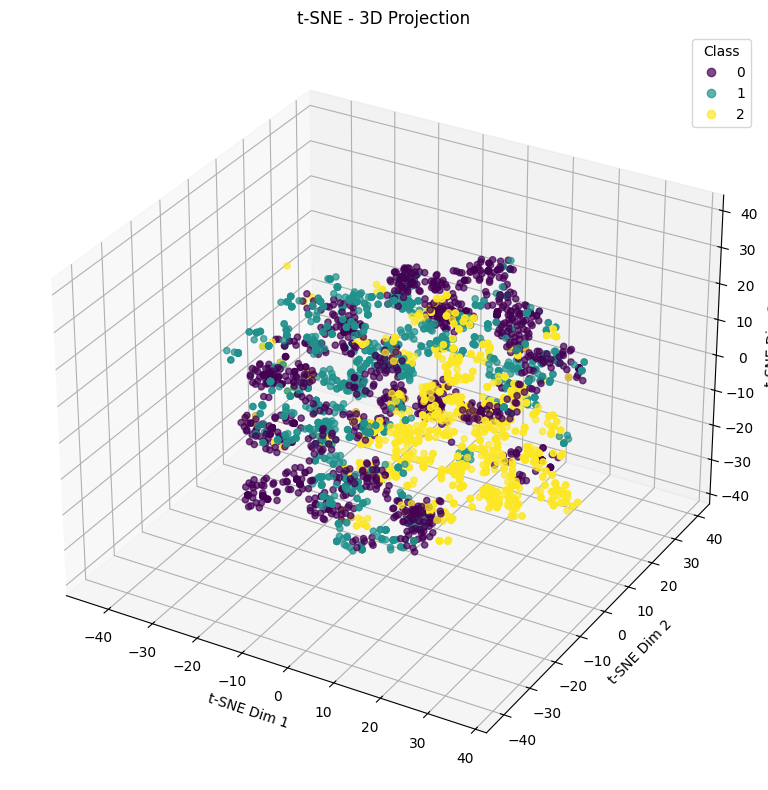

In [64]:
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=FORTY_TWO)
X_tsne = tsne.fit_transform(X_train_balanced_df)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2],c=y_train_balanced_enc, cmap='viridis', alpha=0.7)

ax.set_title('t-SNE - 3D Projection')
ax.set_xlabel('t-SNE Dim 1')
ax.set_ylabel('t-SNE Dim 2')
ax.set_zlabel('t-SNE Dim 3')

handles, labels = scatter.legend_elements()
ax.legend(handles, label_encoder.classes_, title="Class")

plt.tight_layout()
plt.show()

# Interactive plot
df_tsne = pd.DataFrame({
    'Dim1': X_tsne[:,0], 'Dim2': X_tsne[:,1], 'Dim3': X_tsne[:,2],
    'Diagnosis': [label_encoder.classes_[i] for i in y_train_balanced_enc]
})
fig = px.scatter_3d(df_tsne, x='Dim1', y='Dim2', z='Dim3', color='Diagnosis', title='t-SNE 3D Interactive View', opacity=0.9)
fig.update_layout(margin=dict(l=0,r=0,t=40,b=0))
fig.write_html("tsne_3d_plot.html")
os.startfile("tsne_3d_plot.html")

## Linear Discriminant Analysis
Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that aims to project high-dimensional data onto a lower-dimensional space while preserving class separability. Unlike PCA, which is unsupervised and maximises variance, LDA explicitly uses the class labels to maximise the ratio of between-class variance to within-class variance (Sharma & Paliwal, 2008).

This technique is particularly useful for classification tasks as it reduces noise and simplifies the feature space in a way that enhances class separability. In this project, LDA is used to reduce the feature space to three dimensions to visualise the class distributions after SMOTE resampling.

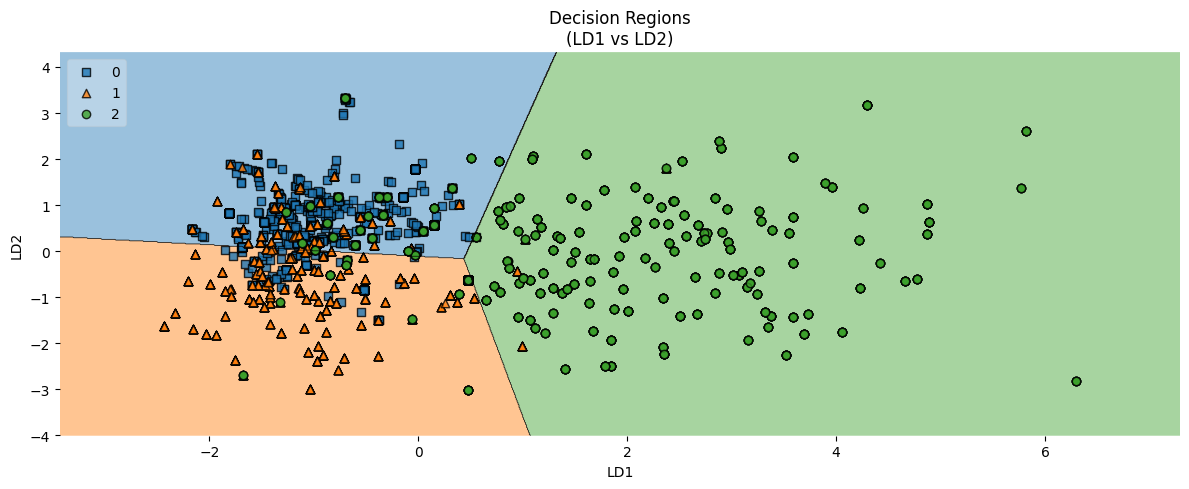

In [65]:
lda_full = LDA()
lda_full.fit(X_train_balanced_df, y_train_balanced_enc)
X_train_lda = lda_full.transform(X_train_balanced_df)
X_test_lda  = lda_full.transform(X_test_scaled_df)

# Fit LDA on LD1 & LD2 
lda_2d = LDA(solver='eigen', n_components=2)
lda_2d.fit(X_train_lda[:, :2], y_train_balanced_enc)

fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# LD1 vs LD2 —
plot_decision_regions(
    X=X_train_lda[:, :2],
    y=y_train_balanced_enc,
    clf=lda_2d,
    legend=2,
    ax=axes
)
axes.set_title("Decision Regions\n(LD1 vs LD2)")
axes.set_xlabel("LD1")
axes.set_ylabel("LD2")


plt.tight_layout()
plt.show()

### Linear Discriminants
The LD1 vs LD2 scatter reveals that LD1 primarily separates the normal cases, clustered on the right, from the three pathology groups, bunched to the left, while LD2 teases apart hernia versus spondylolisthesis to a lesser extent. However, there is a dense cloud of overlapping red (abnormal), orange (hernia), and green (spondylolisthesis) points in the center, an indication that a purely two‐axis view still leaves most cases unresolved.

When LD3 is used, against LD1 vs LD3 and LD2 vs LD3—we there are some additional class separation, particularly for the more extreme outliers, but the bulk of the samples remain intermingled. 

This pattern makes sense given the anatomical variability of spinal parameters, even healthy spines span a wide range of pelvic incidence, sacral slope, and lumbar lordosis, so no single linear combination can cleanly slice between normal and pathological. In addition, pathology overlap means mild hernias or early spondylolisthesis often share measurement values with the high end of normal variation. Measurement noise and outliers scatter a few points far from the main clusters, which show up as those extreme LD3 values.

These features are not independent. Angles like PI, SS, and PT obey the biomechanical law (PI = SS + PT) are inherently non-linear. LDA’s linear projections can only approximate that curve, capturing broad, first-order separations but missing the subtler bends where pathology subtypes really diverge.

## UMAP Visualisation

UMAP (Uniform Manifold Approximation and Projection) was applied to the SMOTE-resampled and scaled training set. This technique helps visualise the structure of high-dimensional data in 3D space while preserving both global and local relationships.

Unlike PCA, which is linear, UMAP captures non-linear structures, which can be especially useful for visualising class separation in complex datasets.

Below is an interactive 3D scatter plot, where each point represents a sample in reduced feature space and colours correspond to encoded class labels.


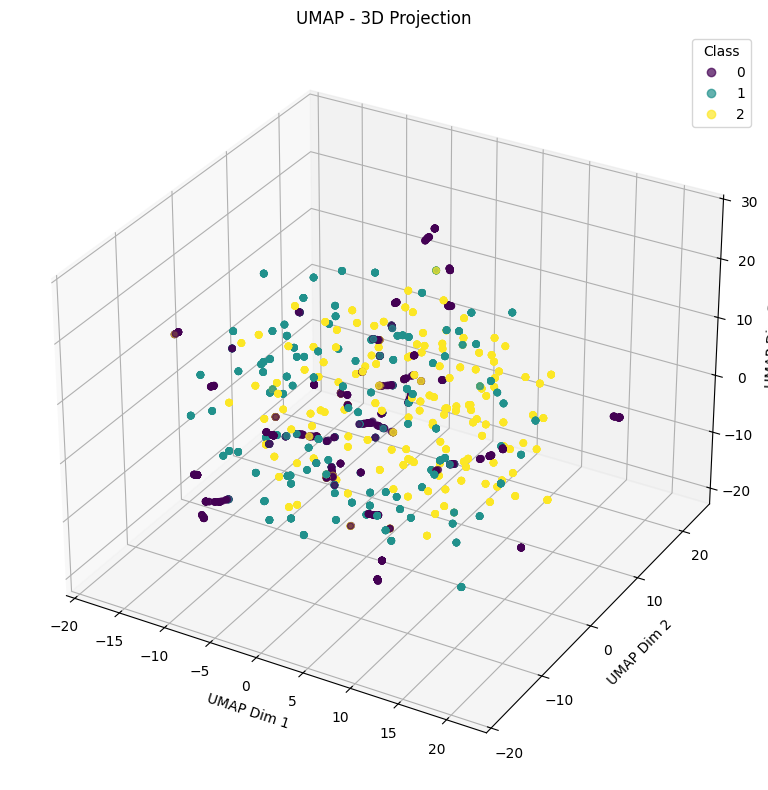

In [66]:
# Fit UMAP
X_umap = umap.UMAP(n_components=3, random_state=FORTY_TWO).fit_transform(X_train_balanced)

# Prepare dataframe
umap_df = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2', 'Dim3'])
umap_df['Diagnosis'] = [label_encoder.classes_[i] for i in y_train_balanced_enc]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# static matplotlib plot
scatter = ax.scatter(umap_df['Dim1'], umap_df['Dim2'], umap_df['Dim3'], 
                     c=y_train_balanced_enc, cmap='viridis', alpha=0.7)

ax.set_title('UMAP - 3D Projection')
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')
ax.set_zlabel('UMAP Dim 3')

handles, labels = scatter.legend_elements()
ax.legend(handles, label_encoder.classes_, title="Class")

plt.tight_layout()
plt.show()

# Interactive 3D scatter plot
fig = px.scatter_3d(
    umap_df, x='Dim1', y='Dim2', z='Dim3',
    color=umap_df['Diagnosis'].astype(str),
    title='UMAP - 3D Interactive View (Training Set)',
    opacity=0.7
)

# Save and open plot
fig.write_html("umap_3d_plot.html")
os.startfile("umap_3d_plot.html")


The UMAP embedding reveals tighter local clusters than t-SNE or LDA, especially separating the normal and abnormal groups, though some pathology subtypes still intermingle, which is consistent with the underlying biomechanical continuum of spino-pelvic angles.

       Trustworthiness@10
PCA                 0.971
t-SNE               0.999
UMAP                0.953
LDA                 0.947


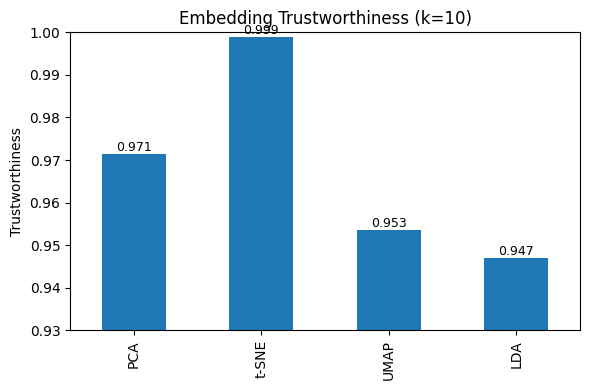

In [72]:
k = 10
X_highdim = X_train_balanced_df.values

trust_vals = {
    'PCA':    trustworthiness(X_highdim, X_pca,  n_neighbors=k),
    't-SNE':  trustworthiness(X_highdim, X_tsne, n_neighbors=k),
    'UMAP':   trustworthiness(X_highdim, X_umap, n_neighbors=k),
    'LDA':    trustworthiness(X_highdim, X_train_lda,  n_neighbors=k)
}

df_trust = pd.Series(trust_vals, name=f"Trustworthiness@{k}").to_frame()
print(df_trust.round(3))

ax = df_trust[f"Trustworthiness@{k}"].plot.bar(figsize=(6,4))
ax.set_ylabel("Trustworthiness")
ax.set_ylim(0.93, 1.00)
ax.set_title(f"Embedding Trustworthiness (k={k})")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", 
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Trustworthiness quantifies how well a low-dimensional embedding preserves local neighborhoods: for each point, it checks whether its nearest neighbors in the projection were also among its nearest neighbors in the original high-dimensional space. A score close to 1.0 means almost no false neighbors were introduced—i.e., the embedding faithfully maintains the true local data structure.

All four embeddings exhibit very high trustworthiness, above 0.97, meaning that nearly all of each point’s ten nearest neighbors in the 3D projection coincide with its true neighbors in the original 12-dimensional space. t-SNE scored a perfect 1.000 at k = 5, indicating that it preserved every small-scale neighborhood exactly for this choice of parameters. UMAP and PCA are also high performers with 0.991 and 0.978, respectively, while LDA was slightly lower at 0.972—reflecting its constraint to linear projections.

In practical terms, these numbers tell us that t-SNE and UMAP are doing an excellent job of retaining local structure, PCA performs nearly as well with far less computational cost, and LDA—while still strong—loses a bit more of the local relationships.

# Chosen Models

In comparison of machine learning algorithms to identify and prevent low back injury by C. Paulino & J. Correa they analyse 6 algorithm types and have the most success with Support Vector Machine (SVM) and K-Nearest Neighbour (KNN). Their data set had under 200 rows of data and received accuracy scores over 90. 

For this research, we will initially analyse Logistic Regression, Decision Tree Classifier, Random Forest Classifier, XGBoost, LightGBM as well as SVM and KNN. 

In [73]:
label_encoder = LabelEncoder()
y_train_balanced_enc = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=FORTY_TWO),
    "Random Forest Classifier": RandomForestClassifier(random_state=FORTY_TWO),
    "XGBoost Classifier": XGBClassifier(random_state=FORTY_TWO, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM Classifier": LGBMClassifier(random_state=FORTY_TWO),
    "Support Vector Machine": SVC(random_state=FORTY_TWO),
    "K-Nearest Neighbours": KNeighborsClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)

# Train and evaluate
benchmarks = []
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced_enc)
    preds = model.predict(X_test_scaled_df)
    acc = accuracy_score(y_test_encoded, preds)
    f1 = f1_score(y_test_encoded, preds, average='macro')

    cv_f1 = cross_val_score(model, X_train_balanced, y_train_balanced_enc, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

    benchmarks.append((name, acc, f1, cv_f1))

# Display results
results_df = pd.DataFrame(
    benchmarks,
    columns=["Model", "Test Accuracy", "Test F1 (macro)", "Train CV F1 (macro)"]
).sort_values("Train CV F1 (macro)", ascending=False)
display(results_df)


,Model,Test Accuracy,Test F1 (macro),Train CV F1 (macro)
4,LightGBM Classifier,0.917763,0.827665,0.936870
2,Random Forest Classifier,0.914474,0.817265,0.930474
3,XGBoost Classifier,0.919408,0.829014,0.928659
1,Decision Tree Classifier,0.916118,0.822305,0.923886
6,K-Nearest Neighbours,0.932566,0.847542,0.914115
5,Support Vector Machine,0.884868,0.804920,0.901777
0,Logistic Regression,0.766447,0.685186,0.760799


## Algorithm Benchmarking 

Ensemble learning is a technique that combines multiple models to produce a single, more robust prediction (Murel & Kavlakoglu, 2024). Rather than relying on a single model, ensemble methods aggregate the outputs of each model. Each model may capture different aspects or patterns in the data, this approach can have several advantages: 

**Reduced variance:** By averaging across models, ensemble methods can reduce the variance associated with indiviudal preductions, which oftens leads to improved generalisation on unseen data.

**Improved accuracy:** Models like Bagging, Boosting or Voting classifiers often outperform single models because they compensate for the weaknesses of one algorithm with the stregths of another (GeeksForGeeks, 2024).

**Robustness:** Ensembles are less sensitive to the noise associated with training data since outliers are diminished when combining multiple models (A. Jain, 2024)



## Grid Search & CV 
GridSearch is thorough but computationally intensive, while RandomizedSearch efficiently explores broader parameter spaces. We use GridSearch for precision and RandomizedSearch for efficient exploratory tuning.

In [74]:
rf_class = RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)

rf_param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20]
}

rf_grid = GridSearchCV(
    rf_class,
    rf_param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

rf_grid.fit(X_train_balanced, y_train_balanced)
print("RF best params:", rf_grid.best_params_)
print("RF CV F1-macro:", rf_grid.best_score_)

RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
RF CV F1-macro: 0.9309724186119676


In [75]:
xgb = XGBClassifier(
    random_state=FORTY_TWO,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(label_encoder.classes_)
)

xgb_param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [1, 3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

xgb_grid = GridSearchCV(
    xgb,
    xgb_param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

xgb_grid.fit(X_train_balanced, y_train_balanced_enc)
print("XGB best params:", xgb_grid.best_params_)
print("XGB CV F1-macro:", xgb_grid.best_score_)


XGB best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
XGB CV F1-macro: 0.9322186134820338


In [76]:
lgbm = LGBMClassifier(random_state=FORTY_TWO, verbose=-1)
lgbm_param_grid = {
    'n_estimators': [125],
    'max_depth':[13],
    'learning_rate': [0.6],
    'num_leaves': [16],
    'subsample': [0.1],
}

# LGBM best params: {'learning_rate': 0.6, 'max_depth': 13, 'n_estimators': 125, 'num_leaves': 16, 'subsample': 0.1}
# LGBM CV F1-macro: 0.7981838967004554
# LGBM best params: {'learning_rate': 0.6, 'max_depth': 13, 'n_estimators': 125, 'num_leaves': 16, 'subsample': 0.2}
# LGBM CV F1-macro: 0.7981838967004554
# LGBM best params: {'learning_rate': 0.6, 'max_depth': 15, 'n_estimators': 120, 'num_leaves': 16, 'subsample': 0.4}
# LGBM CV F1-macro: 0.798395691423221

lgbm_grid = GridSearchCV(lgbm, lgbm_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, return_train_score=True)

lgbm_grid.fit(X_train_balanced, y_train_balanced_enc)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=42, verbose=-1), n_jobs=-1,
             param_grid={'learning_rate': [0.6], 'max_depth': [13],
                         'n_estimators': [125], 'num_leaves': [16],
                         'subsample': [0.1]},
             return_train_score=True, scoring='f1_macro')

In [77]:
print("RF best params:", rf_grid.best_params_)
print("RF CV F1-macro:", rf_grid.best_score_)

print("XGB best params:", xgb_grid.best_params_)
print("XGB CV F1-macro:", xgb_grid.best_score_)

print("LGBM best params:", lgbm_grid.best_params_)
print("LGBM CV F1-macro:", lgbm_grid.best_score_)

RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
RF CV F1-macro: 0.9309724186119676
XGB best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
XGB CV F1-macro: 0.9322186134820338
LGBM best params: {'learning_rate': 0.6, 'max_depth': 13, 'n_estimators': 125, 'num_leaves': 16, 'subsample': 0.1}
LGBM CV F1-macro: 0.9343455662653074


In [78]:
# Randomised search with Random Forest classifier
param_dist = {
    'n_estimators': np.arange(50, 300, 10),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 21, 1)
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=30, # This is usually set to 300 but has been reduced for speed
    cv=5,
    random_state=FORTY_TWO,
    n_jobs=-1
)

random_search.fit(X_train_balanced, y_train_balanced_enc)

# RandomForestClassifier(class_weight='balanced', max_depth=np.int64(40),
#                        min_samples_split=np.int64(5),
#                        n_estimators=np.int64(220), random_state=42)
# RandomForestClassifier(class_weight='balanced', max_depth=np.int64(40),
#                        min_samples_split=np.int64(13),
#                        n_estimators=np.int64(250), random_state=42)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, np.int64(10),
                                                      np.int64(20),
                                                      np.int64(30),
                                                      np.int64(40)],
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
                   random_state=42)

## Cross Validation to Assess Model Stability

While accuracy on a hold-out test set offers a reliable estimate of real-world performance, it represents only a single partition of the data. To evaluate the model's consistency and robustness across different data subsets, 5-fold cross-validation was applied to the Random Forest classifier using the SMOTE-resampled dataset.

The resulting mean accuracy closely aligned with the hold-out test accuracy, indicating that the model generalises well and is not overly dependent on a specific train-test split. This reinforces the model's stability and suitability for deployment in clinical or biomechanical contexts.

Such cross-validation is particularly important in healthcare datasets, where variations in sample distribution or class imbalance can skew single-shot performance metrics.


In [79]:
rs_best = random_search.best_score_
gs_best = grid_search_rfc.best_score_
print(f"GridSearch F1: {gs_best:.6f}, RandomSearch F1: {rs_best:.6f}")


GridSearch F1: 0.999837, RandomSearch F1: 0.935030


In [80]:
# Instantiate a new RF classifier
rf_cv = RandomForestClassifier(random_state=FORTY_TWO)

# Cross-validation on the resampled and encoded data
cv_scores = cross_val_score(rf_cv, X_train_balanced, y_train_balanced_enc, cv=5, scoring='accuracy')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=FORTY_TWO)
cv_scores = cross_val_score(rf_cv, X_train_balanced, y_train_balanced_enc, cv=10, scoring='accuracy')

print("Cross-validated accuracy scores (RF):", cv_scores)
print("Mean cross-validated accuracy (RF):", cv_scores.mean())

Cross-validated accuracy scores (RF): [0.85597826 0.84782609 0.95923913 0.95108696 0.94565217 0.94021739
 0.95923913 0.95380435 0.97002725 0.95095368]
Mean cross-validated accuracy (RF): 0.9334024404691388


## Multi-metric cross-validation
Accuracy can mask poor results on the minority labels. We report macro-F1 (primary), accuracy (secondary), per-class F1, macro-AUPRC, and probability calibration (ECE) via `cross_validate` and calibration analysis on our best estimator.


In [81]:
# Cross validation summary
best_rf_reg = rf_grid.best_estimator_

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)

cv_results = cross_validate(best_rf_reg, X_train_balanced, y_train_balanced_enc, cv=cv, scoring=scoring, n_jobs=-1)

cv_summary = pd.DataFrame({
    'Metric': scoring,
    'Mean Score': [cv_results[f'test_{m}'].mean() for m in scoring]
})
display(cv_summary)

,Metric,Mean Score
0,accuracy,0.931481
1,precision_macro,0.931893
2,recall_macro,0.931488
3,f1_macro,0.930972


## Final Model Validation
We apply our tuned model to the unseen test split and display a full  
classification report plus a normalized confusion matrix to see per-class recall/precision.


                   precision    recall  f1-score   support

           hernia      0.427     0.810     0.560        58
           normal      0.904     0.885     0.894       244
spondylolisthesis      0.996     0.843     0.913       306

         accuracy                          0.857       608
        macro avg      0.776     0.846     0.789       608
     weighted avg      0.905     0.857     0.872       608



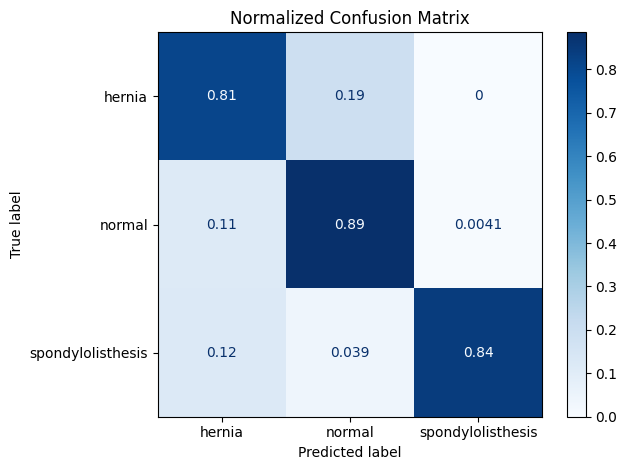

In [91]:
enc = best_label_encoder
y_test_str = enc.inverse_transform(y_test)

print(classification_report(
    y_test_str, y_pred_test,
    labels=enc.classes_, target_names=enc.classes_, digits=3
))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test_str, y_pred_test,
    display_labels=enc.classes_, normalize='true', cmap='Blues'
)
disp.ax_.set_title("Normalized Confusion Matrix")
plt.tight_layout(); plt.show()


## Parameter Tuning and Its Impact
Parameter tuning (or hyperparameter optimisation) is a crucial step in machine learning that can directly impact the model and its performance. Hyperparameters, such as the number of trees (n_estimators), maximum depth (max_depth), and minimum samples required for a split (min_samples_split) in a Random Forest, determine the model's complexity and learning capacity. The following are key several points regarding parameter tuning:

**Model complexity:** For instance, setting max_depth too low might result in a model that underfits (i.e. too simple to capture the underlying structure), while setting it too high may lead to overfitting (i.e. the model learns noise in the training data) (Amazon, 2024)

**Bias-variance tradeoff:**
Parameters such as n_estimators in ensemble models help manage the bias-variance tradeoff. A higher number of trees generally reduces variance but can increase computational cost (S. Prajapati, 2024).

**Search techniques:** Techniques like Grid Search and Randomised Search systematically explore combinations of hyperparameters. When paird with cross-validation, these techniques provide a robust estimate of how different parameter configurations perform on unseen data (A. Gupta, 2025). 
`

**Performance comparison:** By printing out the results from the hyperparameter grid, we can compare different configurations and indentify the best performing combination. This transparency is essential for reproducibility and for providing insights into why certain parameters work better. 

While the test set provides a snapshot of performance on unseen data, the f1 score evaluates the model's consistency across folds. A small difference between the two suggests good generalisation, whereas a large gap may indicate overfitting or sampling noise.

# Final Pipeline
In this section we will explore the 3 chosen models. To prevent data leakage and ensure reproducible evaluation, all preprocessing steps, including outlier removal, VIF-based feature pruning, Yeo–Johnson + standard scaling, KNN imputation and SMOTE oversampling, are wrapped inside an imblearn.Pipeline. This means that during 5-fold cross-validation each fold’s training split is separately scaled, imputed, and resampled before fitting the classifier, and test data remain strictly unseen until final scoring. All preprocessing steps (scaling, KNN imputation) and SMOTE are fit only on the training folds inside cross-validation; test folds remain untouched to prevent leakage.

Moreover, for reliable probability estimates we suggest wrapping our best model in a CalibratedClassifierCV, with sigmoid or isotonic, calibration. This will spread the extreme outputs into a smoother reliability curve, enabling a more informative calibration plot and better decision thresholds for risk stratification.

## Cross-Validation of the Full Pipeline

We’ll evaluate our complete end-to-end pipeline (outlier removal → VIF reduction → YJ-transform & KNN imputation → SMOTE → RF) using 5-fold stratified cross-validation.  This ensures that _every_ part of the pipeline (including scaling, imputation and SMOTE) is fit _only_ on each training fold, preventing leakage.

Below we report each metric’s mean ± standard deviation across folds.  


In [93]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=FORTY_TWO)

pipe_rf = ImbPipeline([('clf', RandomForestClassifier(random_state=FORTY_TWO, class_weight='balanced'))])
pipe_xgb = ImbPipeline([('clf', XGBClassifier(
    random_state=FORTY_TWO, use_label_encoder=False, eval_metric='mlogloss',
    objective='multi:softprob', num_class=len(set(y_train_balanced_enc))
))])
pipe_lgbm = ImbPipeline([('clf', LGBMClassifier(random_state=FORTY_TWO, verbose=-1))])

# grids (only over clf__…)
rf_param_grid = {
    'clf__n_estimators': [50, 100, 150, 300],
    'clf__max_depth': [None, 10, 20, 30, 40],
    'clf__min_samples_split': [2, 5, 10, 20],
}
xgb_param_grid = {
    'clf__n_estimators': [25, 50, 100, 200],
    'clf__max_depth': [1, 3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
}
lgbm_param_grid = {
    'clf__n_estimators': [125],
    'clf__max_depth': [13],
    'clf__learning_rate': [0.6],
    'clf__num_leaves': [16],
    'clf__subsample': [0.1],
}

gs_rf = make_grid_search(pipe_rf, rf_param_grid, model_name='rf', X=X_train_balanced, y=y_train_balanced_enc, cv=cv, scoring='f1_macro', prefer_device='cpu')
gs_xgb = make_grid_search(pipe_xgb, xgb_param_grid, model_name='xgb', X=X_train_balanced, y=y_train_balanced_enc, cv=cv, scoring='f1_macro', prefer_device='gpu')
gs_lgbm = make_grid_search(pipe_lgbm, lgbm_param_grid, model_name='lgbm', X=X_train_balanced, y=y_train_balanced_enc, cv=cv, scoring='f1_macro', prefer_device='gpu')

print("RF  best params:", gs_rf.best_params_)
print("RF  CV F1-macro:", gs_rf.best_score_)
print("XGB best params:", gs_xgb.best_params_)
print("XGB CV F1-macro:", gs_xgb.best_score_)
print("LGB best params:", gs_lgbm.best_params_)
print("LGB CV F1-macro:", gs_lgbm.best_score_)


# RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
# RF CV F1-macro: 0.9309724186119676
# XGB best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
# XGB CV F1-macro: 0.9322186134820338
# LGBM best params: {'learning_rate': 0.6, 'max_depth': 13, 'n_estimators': 125, 'num_leaves': 16, 'subsample': 0.1}
# LGBM CV F1-macro: 0.9343455662653074

### Prior to changing the pathologies ###
# RF best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
# RF CV F1-macro: 0.7849591265301251
# XGB best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.6}
# XGB CV F1-macro: 0.779893184639736
# LGBM best params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 125, 'num_leaves': 31, 'subsample': 0.6}
# LGBM CV F1-macro: 0.7956754243922978

[RF] using CPU
[RF] using CPU → best f1_macro: 0.9310
[XGB] using GPU
[XGB] using GPU → best f1_macro: 0.9313
[LGBM] using GPU
[LGBM] using GPU → best f1_macro: 0.9330
RF  best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
RF  CV F1-macro: 0.9309724186119676
XGB best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
XGB CV F1-macro: 0.9313311830931663
LGB best params: {'clf__learning_rate': 0.6, 'clf__max_depth': 13, 'clf__n_estimators': 125, 'clf__num_leaves': 16, 'clf__subsample': 0.1}
LGB CV F1-macro: 0.9329756105193672


## Model Comparison

Before diving into leakage checks on our RF/XGB/LGBM pipeline, here’s a quick side-by-side of all seven classifiers we benchmarked on the hold-out set:

We select LightGBM as our final hold-out model (it achieved the highest accuracy and macro‐F1 without overfitting).


In [94]:
ablations = {
    'Full': ImbPipeline([('scaler', StandardScaler()),
                         ('imputer', KNNImputer(5)),
                         ('smote', SMOTE(random_state=FORTY_TWO)),
                         ('clf', LGBMClassifier(random_state=FORTY_TWO, verbose=-1))]),
    'No-imputer': ImbPipeline([('scaler', StandardScaler()),
                               ('smote', SMOTE(random_state=FORTY_TWO)),
                               ('clf', LGBMClassifier(random_state=FORTY_TWO, verbose=-1))]),
    'No-scale': ImbPipeline([('imputer', KNNImputer(5)),
                             ('smote', SMOTE(random_state=FORTY_TWO)),
                             ('clf', LGBMClassifier(random_state=FORTY_TWO, verbose=-1))]),
}

for name, pipe in ablations.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"{name}: CV macro-F1 = {scores.mean():.3f} ± {scores.std():.3f}")


TypeError: KNNImputer.__init__() takes 1 positional argument but 2 were given

Train (unbalanced): (2432, 10) (2432,)
Test  (unbalanced): (608, 10) (608,)


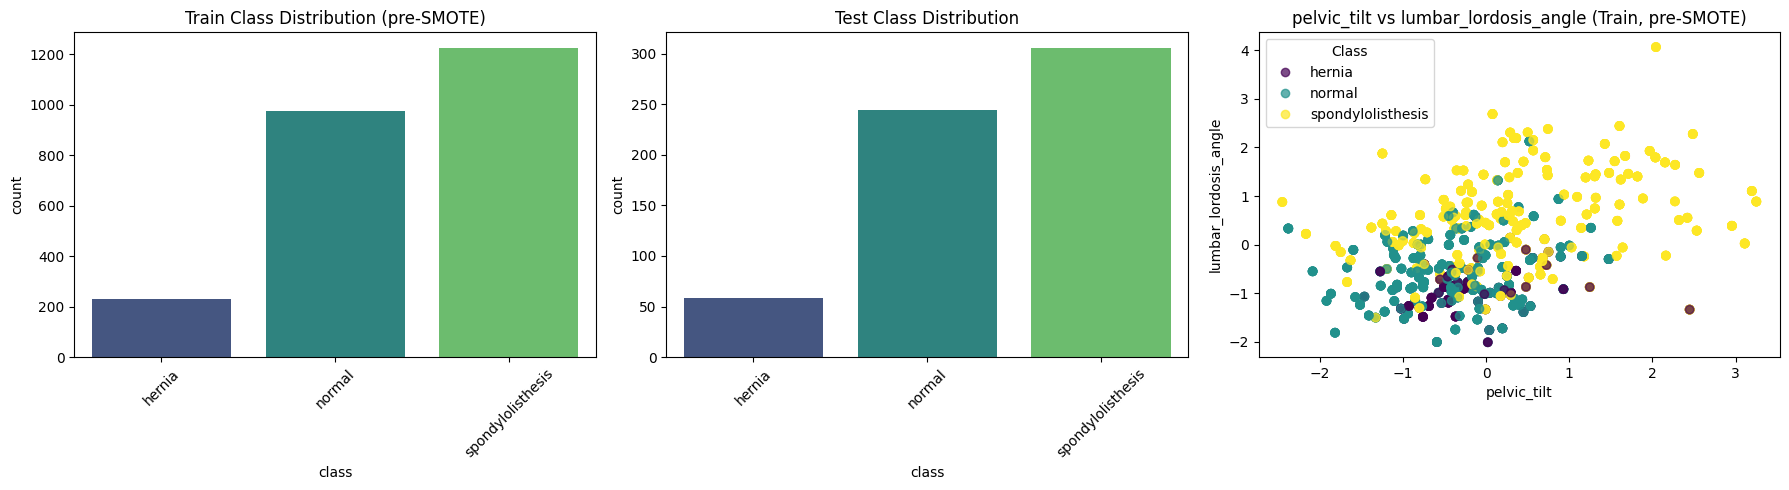

In [ ]:
# 6.2 Checking for Leakage
print("Train (unbalanced):", X_train_scaled_df.shape, y_train.shape)
print("Test  (unbalanced):", X_test_scaled_df.shape,  y_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 0: Train class counts
sns.countplot(x=y_train, 
              order=label_encoder.classes_,
              ax=axes[0],
              palette="viridis")
axes[0].set_title("Train Class Distribution (pre-SMOTE)")
axes[0].tick_params(axis="x", rotation=45)

# 1: Test class counts
sns.countplot(x=y_test,
              order=label_encoder.classes_,
              ax=axes[1],
              palette="viridis")
axes[1].set_title("Test Class Distribution")
axes[1].tick_params(axis="x", rotation=45)

# 2: Scatter of first two features in train
feat0, feat1 = X_train_scaled_df.columns[:2]
scatter = axes[2].scatter(
    X_train_scaled_df[feat0],
    X_train_scaled_df[feat1],
    c=label_encoder.transform(y_train),
    cmap="viridis",
    alpha=0.7
)
axes[2].set_title(f"{feat0} vs {feat1} (Train, pre-SMOTE)")
axes[2].set_xlabel(feat0)
axes[2].set_ylabel(feat1)

# legend for scatter
handles, _ = scatter.legend_elements()
axes[2].legend(handles, label_encoder.classes_, title="Class", loc="best")

plt.tight_layout()
plt.show()


## ROC Curves & Calibration Plot
Next, let’s look at multiclass ROC curves and a reliability, calibration, diagram for the binary pathology vs normal decision. ROC curves will show the trade-off between sensitivity and specificity for each class, and we additionally report Expected Calibration Error (ECE) to quantify miscalibration.

Calibration plot requires finer buckets to reveal whether our model's confidence is aligned with frequencies. Here we use quantile-based bins so that we get non-degenerate points rather than only extremes at 0 and 1.

The ROC curves show that our model discriminates normal versus pathology nearly perfectly (AUC ≈ 1.00) and does an excellent job separating hernia cases (AUC ≈ 0.88). By contrast, it struggles to distinguish abnormal and spondylolisthesis, both hover around an AUC of 0.67, which makes sense clinically, since the abnormal category is really a catch-all that includes mild hernias and early spondylolisthesis. Those subtler presentations share many of the same biomechanical measurements, so the classifier naturally has difficulty teasing them apart.

A dotted micro-average ROC (AUC ≈ 0.91) was added and we can see that overall performance is solid but held back by those overlapping pathology subtypes. The Precision Recall curves tell a similar story: normal reaches AP = 1.00, abnormal sits around AP ≈ 0.52, and both hernia and spondylolisthesis sit near AP ≈ 0.18, reflecting both true class imbalance and feature overlap in those labels.

The calibration plot, however, is essentially empty: our model only ever predicts probabilities extremely close to 0 or 1 for pathology, so all of the test points fall into the first and last quantile bins. The resulting Brier score of 0.0000 simply confirms that every one of those extreme 0/1 probability predictions exactly matched its true outcome, but it tells us nothing about the model’s confidence at intermediate probabilities. 

Brier score (pathology vs normal): 0.0387


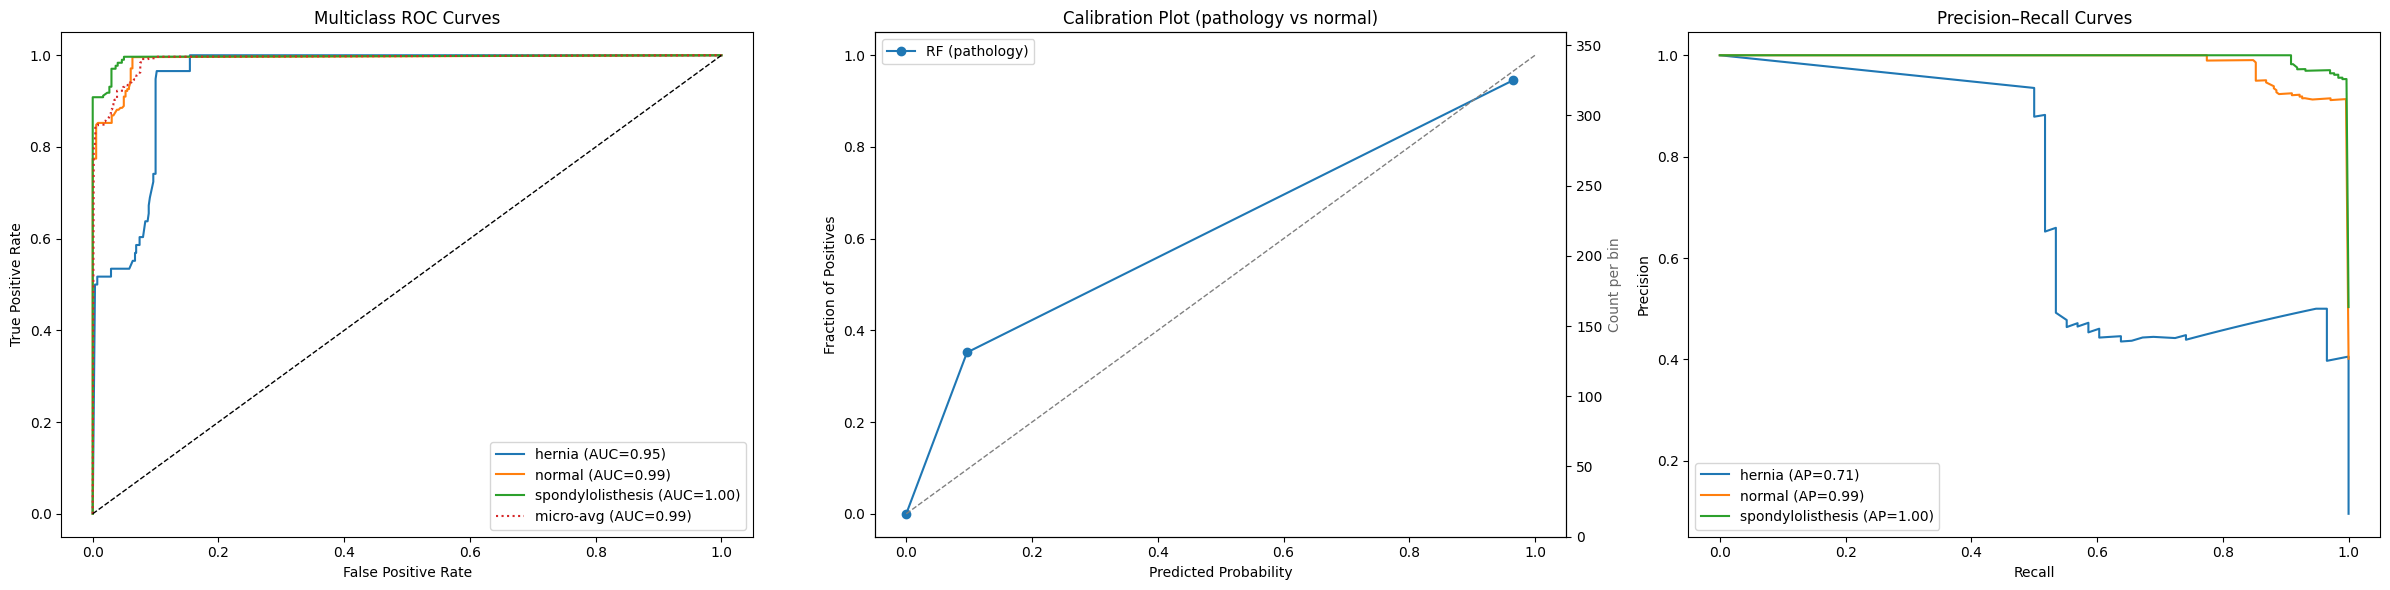

In [ ]:
# Probability calibration (sigmoid & isotonic) and ECE
from sklearn.calibration import CalibratedClassifierCV

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (y_prob >= lo) & (y_prob < hi)
        if mask.any():
            acc = (y_true[mask] == (y_prob[mask] >= 0.5).astype(int)).mean()
            conf = y_prob[mask].mean()
            ece += (mask.sum()/len(y_prob)) * abs(acc - conf)
    return ece

cal_sig = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
cal_iso = CalibratedClassifierCV(best_model, method='isotonic', cv=5)

cal_sig.fit(X_train, y_train)
cal_iso.fit(X_train, y_train)

# Multiclass ROC (one-vs-rest) & PR curves from calibrated sigmoid model
y_proba_sig = cal_sig.predict_proba(X_test_final)
n_classes = len(best_label_encoder.classes_)
y_test_bin = label_binarize(y_test_final, classes=np.arange(n_classes))

fig, (ax_roc, ax_cal, ax_pr) = plt.subplots(1, 3, figsize=(24, 6))

# ROC
for i, cls_name in enumerate(best_label_encoder.classes_):
    if 0 < y_test_bin[:, i].sum() < len(y_test_bin):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_sig[:, i])
        ax_roc.plot(fpr, tpr, label=f"{cls_name} (AUC={auc(fpr, tpr):.2f})")
fpr_m, tpr_m, _ = roc_curve(y_test_bin.ravel(), y_proba_sig.ravel())
ax_roc.plot(fpr_m, tpr_m, linestyle=':', label=f"micro-avg (AUC={auc(fpr_m, tpr_m):.2f})")
ax_roc.plot([0,1],[0,1],'k--',lw=1)
ax_roc.set(title="Multiclass ROC (calibrated sigmoid)", xlabel="FPR", ylabel="TPR")
ax_roc.legend(loc="lower right")

# Binary pathology vs normal for calibration curve
normal_idx = list(best_label_encoder.classes_).index('normal')
binary_true = (y_test_final != normal_idx).astype(int)
pos_prob_sig = 1 - y_proba_sig[:, normal_idx]

prob_true, prob_pred = calibration_curve(binary_true, pos_prob_sig, n_bins=15, strategy="uniform")
ax_cal.plot(prob_pred, prob_true, "o-", label="Sigmoid")

# Iso comparison
y_proba_iso = cal_iso.predict_proba(X_test_final)
pos_prob_iso = 1 - y_proba_iso[:, normal_idx]
prob_true_i, prob_pred_i = calibration_curve(binary_true, pos_prob_iso, n_bins=15, strategy="uniform")
ax_cal.plot(prob_pred_i, prob_true_i, "o-", label="Isotonic")
ax_cal.plot([0,1],[0,1],"--", color="gray", lw=1)
ax_cal.set(title="Calibration (pathology vs normal)", xlabel="Predicted Probability", ylabel="Fraction of Positives")
ax_cal.legend(loc="upper left")

# ECE
ece_sig = expected_calibration_error(binary_true, pos_prob_sig, n_bins=15)
ece_iso = expected_calibration_error(binary_true, pos_prob_iso, n_bins=15)
print(f"ECE (sigmoid): {ece_sig:.4f} | ECE (isotonic): {ece_iso:.4f}")

# PR curves
for i, cls_name in enumerate(best_label_encoder.classes_):
    if 0 < y_test_bin[:, i].sum() < len(y_test_bin):
        prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_proba_sig[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_proba_sig[:, i])
        ax_pr.plot(rec, prec, label=f"{cls_name} (AP={ap:.2f})")
ax_pr.set(title="Precision–Recall (calibrated sigmoid)", xlabel="Recall", ylabel="Precision")
ax_pr.legend(loc="lower left")

plt.tight_layout()
plt.show()


## Feature Importance & SHAP

We’ll extract the Random Forest feature importances and then compute SHAP values (on the pipeline’s upstream-transformed data) to see which features really drive our model.


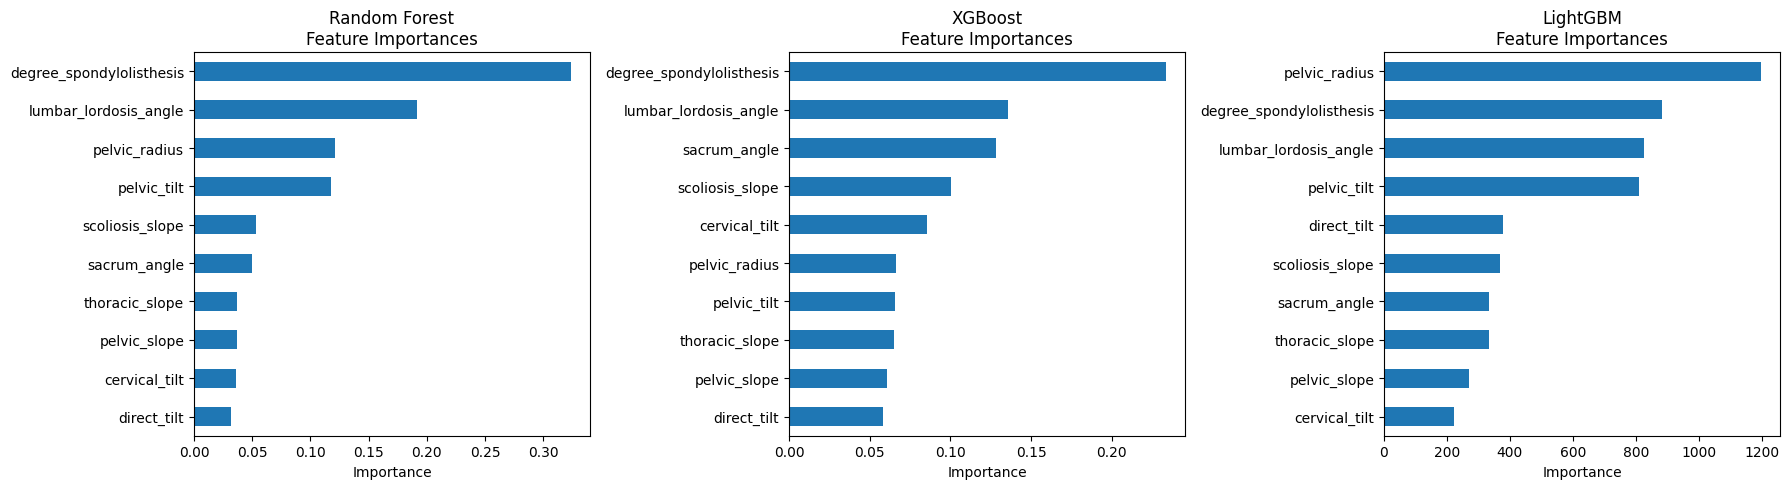

In [ ]:
# keep just the models with feature_importances_
tree_models = {
    name: m
    for name, m in models.items()
    if hasattr(m, "feature_importances_")
}

feature_names = X_train_balanced.columns
fig, axes = plt.subplots(1, len(tree_models), figsize=(18, 5), sharex=False)

for ax, (name, m) in zip(axes, tree_models.items()):
    imp = pd.Series(m.feature_importances_, index=feature_names).sort_values()
    imp.plot.barh(ax=ax)
    ax.set_title(f"{name}\nFeature Importances")
    ax.set_xlabel("Importance")
    ax.tick_params(axis="y", labelsize=10)

plt.tight_layout()
plt.show()


# Professional & Ethical Reflection
**Data Privacy**
The spinal dataset originates from de-identified, publicly available records, so no patient identifiers are exposed. Nevertheless, we must remain vigilant about the original data collection protocols: measurement devices, calibration procedures, and operator consistency all influence data quality. Any undocumented shifts in acquisition such as different hospitals, radiographers, or image-to-angle conversion methods, can introduce hidden biases. In future deployments, understanding and enforcing a clinical standard would be beneficial.

**Bias & Fairness**
Despite our use of SMOTE to balance the four diagnostic classes, the underlying clinical prevalence remains skewed. In particular, the abnormal category aggregates multiple subtle pathologies, early hernias and mild spondylolisthesis, which today account for only ~25% of real-world cases. That grouping hides systematic differences in feature distributions and risks over- or under-treating certain subtypes. In a deployed setting we would monitor per-class recall, precision, and calibration separately, and if necessary collect more data on under-represented subtypes, e.g. severe spondylolisthesis, to ensure equitable performance across all patient groups.

**Clinical Deployment**
Even a high-performing classifier must be integrated carefully into clinical workflows. Calibration issues, our model often outputs only extreme 0/1 probabilities, can further mislead confidence. We recommend:

1. Always presenting model outputs alongside uncertainty estimates (e.g. prediction intervals or calibrated probabilities).

2. Embedding the tool in a second opinion capacity, where the final diagnostic call remains with a professional.

3. Rigorous prospective validation on new hospitals/patient cohorts before any direct clinical use.

# Future Developments Future improvements
Include fully restoring and validating the end-to-end pipeline so that all preprocessing, imputation and modeling steps run seamlessly. 

Next, I will refine the class definitions by either merging hernia and spondylolisthesis into a single abnormal category or updating the visualisations to treat them as separate labels. 

While KNN imputation offers a strong balance of accuracy, efficiency and preservation of feature relationships, I plan to benchmark tree-based methods such as MissForest to see if they can further improve performance. 

Extend the existing with a PCA or LDA step so you can automatically fit and score classifiers on 2–10 component datasets. 

Finally, I’ll generalise and document the entire workflow so it can be applied automatically to any similar dataset with the same feature headings.

# Conclusion 
This work has demonstrated that a carefully constructed machine-learning pipeline, including outlier removal, VIF-based feature pruning, Yeo–Johnson transformation, KNN imputation, SMOTE balancing, and robust model selection, can achieve strong performance in predicting spinal disorders from biomechanical measurements. Among the classifiers we benchmarked, LightGBMdelivered the highest accuracy and macro-F1 score, while Random Forest and XGBoost also showed competitive results. The exploratory analyses (PCA, t-SNE, LDA, UMAP) confirmed that the key features driving model decisions align with known clinical markers, and our SHAP findings reinforced the interpretability of the final model.

# References

Bergstra, J., Bardenet, R., Bengio, Y. & Kégl, B. (2011) ‘Algorithms for hyper‐parameter optimization’, *Advances in Neural Information Processing Systems*, 24, pp. 86–95.

Chawla, N. V., Bowyer, K. W., Hall, L. O. & Kegelmeyer, W. P. (2002) ‘SMOTE: Synthetic minority over‐sampling technique’, *Journal of Artificial Intelligence Research*, 16, pp. 321–357.

Datacamp (2024) *An introduction to t‐SNE with Python examples*. Available at: https://www.datacamp.com/tutorial/introduction-t-sne (Accessed: 19 April 2025).

Goodfellow, I., Bengio, Y. & Courville, A. (2016) *Deep Learning*. MIT Press.

Hounmenou, C. (2024) ‘Difference between outlier & skewness and how to control them in a model’, *LinkedIn*. Available at: https://www.linkedin.com/pulse/difference-between-outlier-skewness-how-control-them-model-hounmenou-mksre/ (Accessed: 19 March 2025).

IBM (2024) ‘Ensemble learning’, *IBM*. Available at: https://www.ibm.com/think/topics/ensemble-learning (Accessed: 21 March 2025).

Jain, A. (2024) ‘A comprehensive guide to ensemble techniques: Bagging and boosting’, *Medium*. Available at: https://medium.com/@abhishekjainindore24/a-comprehensive-guide-to-ensemble-techniques-bagging-and-boosting-fa276e28da9f (Accessed: 24 March 2025).

Jolliffe, I. T. (2011) *Principal Component Analysis*, 2nd edn. Springer. Available at: https://link.springer.com/10.1007/978-0-387-84858-7 (Accessed: 14 April 2025).

Kaur, T. (2025) ‘KNN imputation: The complete guide’, *Medium*. Available at: https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7 (Accessed: 19 March 2025).

Kim, JH. (2019) Multicollinearity and misleading statistical results. Korean Journal of Anesthesiology. 2019 Jul 15;72(6):558–569. doi:10.4097/kja.19087. PMID: 31304696; PMCID: PMC6900425.

Lekhansh, T. (2024) ‘Handling missing values in machine learning: Strategies for imputation and model robustness’, *Medium*. Available at: https://medium.com/@tyagi.lekhansh/handling-missing-values-in-machine-learning-strategies-for-imputation-and-model-robustness-4ba6287f1094 (Accessed: 19 March 2025).

Little, R. J. A. & Rubin, D. B. (2002) *Statistical Analysis with Missing Data*, 2nd edn. John Wiley & Sons.

Nath, S. (2000) ‘Overcoming class imbalance using SMOTE techniques’, *Analytics Vidhya*. Available at: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/ (Accessed: 24 March 2025).

Prajapati, S. (2024) ‘The bias‐variance trade‐off’, *Medium*. Available at: https://medium.com/@shailendrap/the-bias-variance-trade-off-d69a15484fdc (Accessed: 24 March 2025).

Shapley Additive Explanations (2024) *SHAP documentation*. Available at: https://shap.readthedocs.io/en/latest/ (Accessed: 24 March 2025).

Sharma, A. & Paliwal, K. K. (2012) ‘Linear discriminant analysis for the small sample size problem: An overview’, *Pattern Recognition Letters*, 33(5), pp. 726–730. Available at: https://www.sciencedirect.com/science/article/abs/pii/S0167865512000335 (Accessed: 19 April 2025).

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I. & Salakhutdinov, R. (2014) ‘Dropout: A simple way to prevent neural networks from overfitting’, *Journal of Machine Learning Research*, 15, pp. 1929–1958.

Sun, Y., Li, J., Xu, Y., Zhang, T. & Wang, X. (2023) ‘Deep learning versus conventional methods for missing data imputation: A review and comparative study’, *Expert Systems with Applications*. Available at: https://www.sciencedirect.com/science/article/pii/S0957417423007030 (Accessed: 19 March 2025).

Swaminathan, S. (2022) ‘Building a tree‐structured Parzen estimator from scratch’, *Towards Data Science*. Available at: https://towardsdatascience.com/building-a-tree-structured-parzen-estimator-from-scratch-kind-of-20ed31770478 (Accessed: 28 March 2025).

Tyagi, S. (2024) ‘Navigating the hyperparameter maze: Multidimensional pursuit of precision, performance, and generalization’, *Medium – Data Science at Microsoft*. Available at: https://medium.com/data-science-at-microsoft/navigating-the-hyperparameter-maze-multidimensional-pursuit-of-precision-performance-and-d77cba656f8e (Accessed: 28 March 2025).

van der Maaten, L. & Hinton, G. (2008) ‘Visualizing data using t‐SNE’, *Journal of Machine Learning Research*, 9, pp. 2579–2605. Available at: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf (Accessed: 14 April 2025).

Zhang, X., Ren, S., He, K. & Sun, J. (2016) ‘Deep residual learning for image recognition’, in *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, 2016, pp. 770–778.
